In [1]:
# Import necessary modules

import warnings

# Filter all warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lazypredict

import pycaret
from pycaret.classification import (setup, compare_models, tune_model)

from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV)

from scipy import stats
from scipy.stats import skew

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, 
VotingClassifier)
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (classification_report, accuracy_score, roc_curve, roc_auc_score)

from sklearn.inspection import permutation_importance

#### Data Wrangling

In [2]:
# Read the csv file

data = pd.read_csv('ACME-HappinessSurvey2020.csv')

In [3]:
# See how the original data looks like

data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


Data Description:

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers

X1 = my order was delivered on time

X2 = contents of my order was as I expected

X3 = I ordered everything I wanted to order

X4 = I paid a good price for my order

X5 = I am satisfied with my courier

X6 = the app makes ordering easy for me

In [4]:
#Rename the columns to have names with meaning for the audience

new_cols = ['customer_happiness', 'delivered_time', 'order_quality','complete_order', 'price_satisfaction', 
           'courier_satisfaction', 'app_satisfaction']

old_cols = list(data.columns)

data.rename(columns=dict(zip(old_cols, new_cols)), inplace=True)

In [5]:
# See if the changes went through

data.head()

,customer_happiness,delivered_time,order_quality,complete_order,price_satisfaction,courier_satisfaction,app_satisfaction
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [6]:
# See the types

data.dtypes

customer_happiness      int64
delivered_time          int64
order_quality           int64
complete_order          int64
price_satisfaction      int64
courier_satisfaction    int64
app_satisfaction        int64
dtype: object

In [7]:
# See Null values for all the columns

data.isna().sum()

customer_happiness      0
delivered_time          0
order_quality           0
complete_order          0
price_satisfaction      0
courier_satisfaction    0
app_satisfaction        0
dtype: int64

In [8]:
# Count the values to see any inconsistencies. An inconsistency would be a value over 5 or under 0

def value_count(df):
    
    for col in df.columns:
        print(col)
        print(df[col].value_counts(ascending = False))
        
value_count(data)

customer_happiness
1    69
0    57
Name: customer_happiness, dtype: int64
delivered_time
5    65
4    40
3    20
1     1
Name: delivered_time, dtype: int64
order_quality
3    42
2    34
1    27
4    17
5     6
Name: order_quality, dtype: int64
complete_order
3    55
4    33
5    17
2    14
1     7
Name: complete_order, dtype: int64
price_satisfaction
4    53
3    41
5    25
2     5
1     2
Name: price_satisfaction, dtype: int64
courier_satisfaction
4    50
5    31
3    22
2    16
1     7
Name: courier_satisfaction, dtype: int64
app_satisfaction
5    57
4    47
3    20
2     1
1     1
Name: app_satisfaction, dtype: int64


### Data Visualization

In this step, I want to look how the data is distributed by making some charts. Additionally, I want to see in what fields the company requires to pay more attention and in what fields they are doing well. Also, I would be doing some statistical inference

In [10]:
# Check if the data is normally distributed

n_bins = np.sqrt(len(data))
n_bins = int(n_bins)

# Create a function to plot the histogram for each feature
# See if the data is normally distributed

def distribution(feature, color, title):
    
    plt.hist(x = feature, bins = n_bins, color = color, data = data)
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.title(title)
    return plt.show()

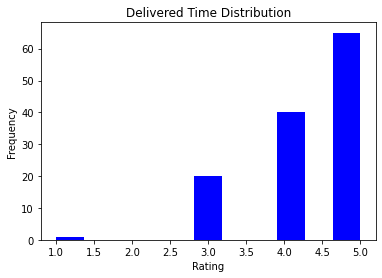

In [11]:
# Delivered time distribution

distribution(feature = 'delivered_time', color = 'blue', title = 'Delivered Time Distribution')

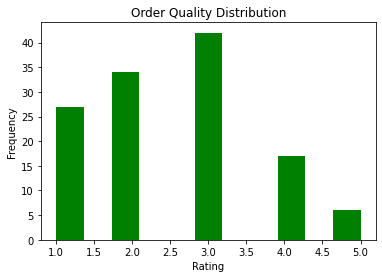

In [12]:
# Order Quality Distribution

distribution(feature = 'order_quality', color = 'green', title = 'Order Quality Distribution')

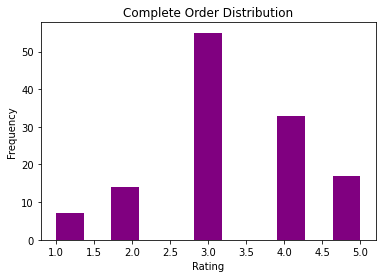

In [13]:
# Complete Order Distribution

distribution(feature = 'complete_order', color = 'purple', title = 'Complete Order Distribution')

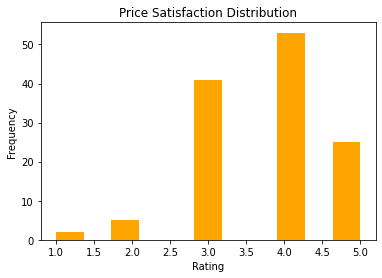

In [14]:
# Price Satisfaction Distribution

distribution(feature = 'price_satisfaction', color = 'orange', title = 'Price Satisfaction Distribution')

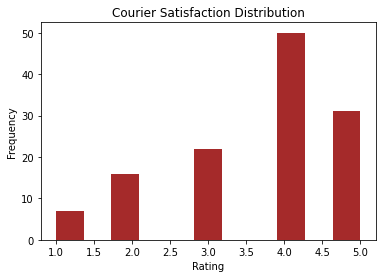

In [15]:
# Courier Satisfaction Distribution

distribution(feature = 'courier_satisfaction', color= 'brown', title = 'Courier Satisfaction Distribution')

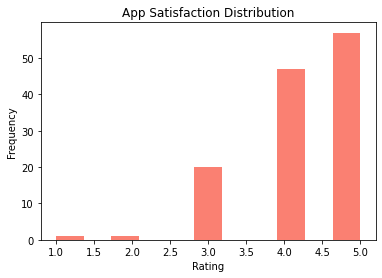

In [16]:
distribution(feature = 'app_satisfaction', color= 'salmon', title = 'App Satisfaction Distribution')

###### From the histograms I got, I can see most of the data is not normally distributed. 
###### delivered_time, price_satisfaction, courier_satisfaction and app_satisfaction look to be skewed to the left
###### order_quality looks to be skewed to the right
###### Finally, complete_order looks to be normal distributed

#### Calculation of skweness

In [17]:
# Calculation of skewness using the pandas function

skewValue = data.skew()

skewValue.sort_values(ascending = False)

order_quality           0.271000
customer_happiness     -0.193659
complete_order         -0.199536
price_satisfaction     -0.422240
courier_satisfaction   -0.699999
app_satisfaction       -0.957590
delivered_time         -1.058468
dtype: float64

###### After the calculation of the skewness, I can conclude the following of the dataset

##### delivered time is highly skewed
##### app_satisfaction, and courier_satisfaction, and price_satisfaction features are moderately skewed.
##### order_quality, complete_order  are approximately normal distributed

In [18]:
# Create a new column that says if customer is happy or no to make easier the plots

data['happiness'] = data['customer_happiness'].map({0: 'unhappy', 1:'happy'})

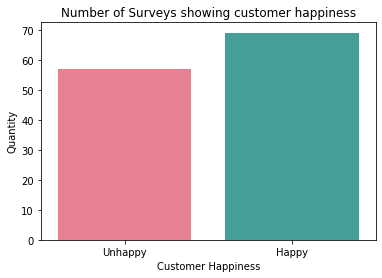

In [19]:
# Create a bar chart to see if there is a signficant difference between happy and unhappy customers

sns.countplot(x = 'customer_happiness', data = data,
            palette = 'husl')
plt.xlabel('Customer Happiness')
plt.ylabel('Quantity')
plt.xticks([0,1],['Unhappy', 'Happy'])
plt.title("Number of Surveys showing customer happiness")
plt.show()

From the correlation matrix, I am supposed to remove order quality, and price satisfaction, but I want to look further with some visualization techniques.

###### From the value counts, I can see there are some fields the company needs to work on to improve ratings and it may help to gain customers.
###### I'm doing different types of grouping to plot different chars that will tell me different insights

In [20]:
# Grouping by app satisfaction and aggregating the number of happy customers. 

data_app_grouped_happy = data.groupby('app_satisfaction').agg({'customer_happiness':'sum'})

# Grouping by app satisfaction and aggregating the number of votings. 

data_app_grouped_all = data.groupby('app_satisfaction').agg({'customer_happiness':'count'})

# Grouping by courier satisfaction and aggregating the number of happy customers. 

data_courier_grouped_happy = data.groupby('courier_satisfaction').agg({'customer_happiness':'sum'})

# Grouping by courier satisfaction and aggregating the number of votings. 

data_courier_grouped_all = data.groupby('courier_satisfaction').agg({'customer_happiness':'count'})

#Grouping by price satisfaction and aggregating the number of happy customers.

data_price_grouped_happy = data.groupby('price_satisfaction').agg({'customer_happiness':'sum'})

# Grouping by price satisfaction and aggregating the number of votings. 

data_price_grouped_all = data.groupby('price_satisfaction').agg({'customer_happiness':'count'})

# Grouping by order quality

data_order_quality_happy = data.groupby('order_quality').agg({'customer_happiness':'sum'})

# Grouping by order quality and aggregating the number of votings. 

data_order_grouped_all = data.groupby('order_quality').agg({'customer_happiness':'count'})

In [21]:
# Grouping by customer happiness and see the average rating in each category

data_grouped = data.groupby('customer_happiness').agg('mean')
data_grouped

,delivered_time,order_quality,complete_order,price_satisfaction,courier_satisfaction,app_satisfaction
customer_happiness,,,,,,
0,4.087719,2.561404,3.140351,3.684211,3.368421,4.105263
1,4.536232,2.507246,3.449275,3.797101,3.884058,4.376812


###### From the grouping data frame, the feature with less rating was the order quality. However, there's not a huge difference between the rating from happy and unhappy customers. Nevertheless, I can conclude the company needs to work to improve the order quality since this is behind from all the metrics. The company is doing well in delivered time and app satifaction and the order completeness is very neutral which is not good and also needs to be improved. 

###### By looking at this, from the modeling, the order quality will not add many value to my model because happy and unhappy customers still have the order quality is generally bad. 

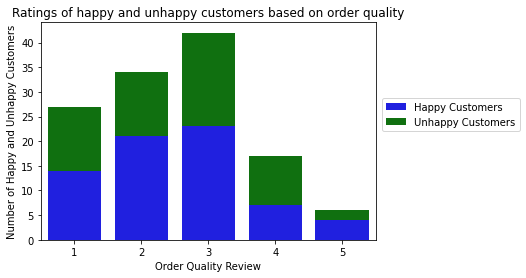

In [22]:
# Save the difference between the votes of all and happy customers to see the number of unhappy votes

diff = data_order_grouped_all - data_order_quality_happy

# See the order quality grouped data frame to see the reviews

sns.barplot(x = data_order_quality_happy.index, y = 'customer_happiness', data = data_order_quality_happy, 
            color = 'blue', label = 'Happy Customers')
sns.barplot(x = diff.index, y = 'customer_happiness', data = diff, bottom = data_order_quality_happy['customer_happiness'],
           color = 'green', label = 'Unhappy Customers')
plt.xlabel('Order Quality Review')
plt.ylabel('Number of Happy and Unhappy Customers')
plt.title('Ratings of happy and unhappy customers based on order quality')
plt.legend(loc = (1.02, 0.5))
plt.show()

###### This bar chart sustained what I mentioned before. The revies of order quality between happy and unhapy customers is very equalized which won't help our modeling.

###### From this plot, most of the reviews are 3 or less which means this is very bad for the company, and also because those are reviews from happy customers that still thinks the order quality is bad.

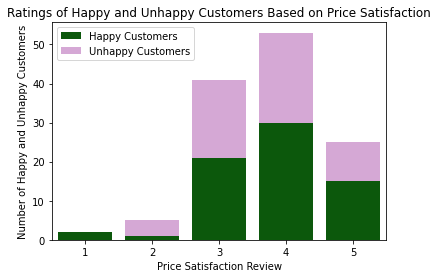

In [23]:
# Save the difference between the votes of all and happy customers to see the number of unhappy votes

diff = data_price_grouped_all - data_price_grouped_happy

# See the order price satisfaction grouped data frame to see the reviews

sns.barplot(x = data_price_grouped_happy.index, y = 'customer_happiness', data = data_price_grouped_happy, 
            color = 'darkgreen',label = 'Happy Customers')
sns.barplot(x = diff.index, y = 'customer_happiness', data = diff, bottom = data_price_grouped_happy['customer_happiness'],
           color = 'plum', label = 'Unhappy Customers')
plt.xlabel('Price Satisfaction Review')
plt.ylabel('Number of Happy and Unhappy Customers')
plt.title('Ratings of Happy and Unhappy Customers Based on Price Satisfaction')
plt.legend(loc = 'best')
plt.show()

##### From this plot, it looks like probably I can get some insights from the price satisfaction to reach out the desired 73% accuracy.

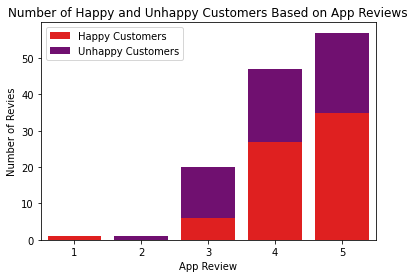

In [24]:
# Calculate the difference between the two grouped data frames to create the bar plot 

diff = data_app_grouped_all - data_app_grouped_happy

#Customer happiness and app reviews

sns.barplot(x = data_app_grouped_happy.index, y = 'customer_happiness', data = data_app_grouped_happy, color = 'red', 
           label = 'Happy Customers')
sns.barplot(x = diff.index, y = 'customer_happiness', data = diff, bottom = data_app_grouped_happy['customer_happiness'],
           color = 'purple', label = 'Unhappy Customers')
plt.xlabel('App Review')
plt.ylabel('Number of Revies')
plt.title('Number of Happy and Unhappy Customers Based on App Reviews')
plt.legend(loc = 'best')
plt.show()

###### Different than the order quality, most of the customers think the app is good enough. However, still the quantity of votes is very equalized, though the difference between the mean is higher, so it is interesting to add the app satisfaction to the model.

###### The company seems to do well to make the app easy to order. The ratings are generally good for happy customers in regards of happy customers

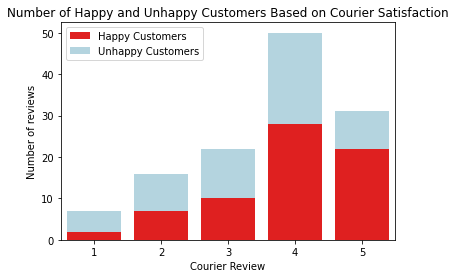

In [25]:
# Calculate the difference of the grouped data frames

diff = data_courier_grouped_all - data_courier_grouped_happy

# Plot the stacked barplot with the courier satisfaction

sns.barplot(x = data_courier_grouped_happy.index, y = 'customer_happiness', data = data_courier_grouped_happy, 
            color = 'red', label = 'Happy Customers')
sns.barplot(x = diff.index, y = 'customer_happiness', data = diff, color = 'lightblue', 
            bottom = data_courier_grouped_happy['customer_happiness'],label = 'Unhappy Customers')
plt.xlabel('Courier Review')
plt.ylabel('Number of reviews')
plt.title('Number of Happy and Unhappy Customers Based on Courier Satisfaction')
plt.legend(loc = 'best')
plt.show()

From the correlation matrix, it supports me to remove order quality because of the low correlation and keep the app satisfaction because it at least higher than 0.1, so I can get insights from it on the model.

#### Correlation Matrix

Plot the correlation matrix to see possible features to remove

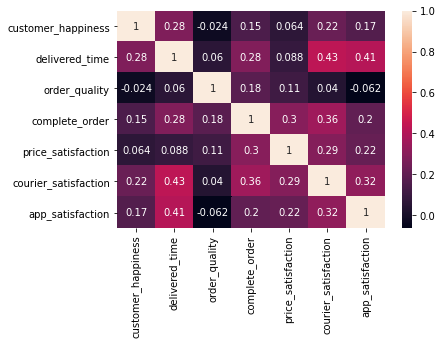

In [26]:
# Create a correlation matrix

corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot = True)
plt.show()

### Exploratory Data Analysis

In [27]:
# Bootstrapping to see the statistical significance for the customer happiness variable
# Calculation of the mean and change the type to integer

customer_happiness = data['customer_happiness'].values.astype('int')
mean = customer_happiness.mean()
print('The current mean for this dataset is {}'.format(mean))

The current mean for this dataset is 0.5476190476190477


In [28]:
# Create a function that returns a list with the list of 1000 different means in case we run the experiment many times
number_attemps = 10000

def bootstrapping_mean(array):
    mean_replicates = []
    bs_replicates = np.empty(number_attemps)
    for i in range(number_attemps):
        bs_replicates = np.random.choice(array, len(array))
        mean_replicates.append(bs_replicates.mean())
    return mean_replicates

In [29]:
# Calculate the confidence interval

mean_replicates = bootstrapping_mean(customer_happiness)
mean_replicates_sorted = sorted(mean_replicates)
lower_bound = np.quantile(mean_replicates_sorted, 0.025)
upper_bound = np.quantile(mean_replicates_sorted, 0.975)
median = np.quantile(mean_replicates_sorted, 0.5)
print('''The 95% confidence interval is between {} and {} that indicates the 95% of confidence intervals where my mean reviews is going to be'''.format(lower_bound, upper_bound))

The 95% confidence interval is between 0.4603174603174603 and 0.6349206349206349 that indicates the 95% of confidence intervals where my mean reviews is going to be


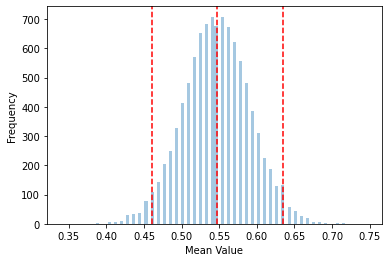

In [30]:
#Visualize a histogram of the mean replicates 
# Try to minimize the bias of the bins distribution

n_bins = np.sqrt(len(mean_replicates))
n_bins = int(n_bins)
sns.distplot(mean_replicates, bins = n_bins, kde = False)
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.axvline(lower_bound, color = 'red', linestyle = '--')
plt.axvline(median, color = 'red', linestyle = '--')
plt.axvline(upper_bound, color = 'red', linestyle = '--')
plt.show()

In [31]:
# See the values below 0.50 (means higher customer unhappiness)

number_unhappy = []

for i in mean_replicates:
    if i < 0.5:
        number_unhappy.append(i)
        
percentage_unhappy = round((len(number_unhappy)/len(mean_replicates))*100,2)      
print('In our bootstrapping, we have a chance of {}% to have more customers unhappy'.format(percentage_unhappy))

In our bootstrapping, we have a chance of 12.41% to have more customers unhappy


### Feature Engineering

In [32]:
# Transform the variables I got that were skewed into normal distributions by applying boxcops transformation

# transform training data & save lambda value 

fitted_data1, fitted_lambda1 = stats.boxcox(data['delivered_time'])

fitted_data2, fitted_lambda2 = stats.boxcox(data['app_satisfaction'])

fitted_data3, fitted_lambda3 = stats.boxcox(data['courier_satisfaction'])

fitted_data4, fitted_lambda4 = stats.boxcox(data['price_satisfaction'])

In [33]:
# Change the existing columns to the new fitted data to have normal distribution and improve the results

data['delivered_time'] = fitted_data1

data['app_satisfaction'] = fitted_data2

data['courier_satisfaction'] = fitted_data3

data['price_satisfaction'] = fitted_data4

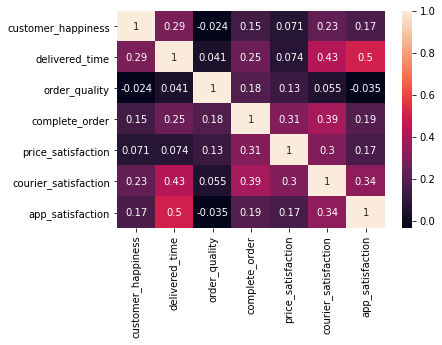

In [34]:
# Plot again the correlation matrix to see if I could still remove order_quality variable

corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot = True)
plt.show()

In [35]:
# Delete order_quality and price_satisfaction

data2 = data[['customer_happiness', 'courier_satisfaction', 'complete_order', 'delivered_time','app_satisfaction',
             ]]

data2 = pd.get_dummies(data2, columns = ['delivered_time','complete_order', 'courier_satisfaction', 'app_satisfaction'
                                       ], drop_first = False)


In [36]:
# Delete order_quality

data3 = data[['customer_happiness', 'courier_satisfaction', 'complete_order', 'delivered_time','app_satisfaction',
             'price_satisfaction']]

data3 = pd.get_dummies(data3, columns = ['delivered_time','complete_order', 'courier_satisfaction', 'app_satisfaction',
                                       'price_satisfaction'], drop_first = False)

In [37]:
# Using the complete dataset

data4 = pd.get_dummies(data, columns = ['delivered_time','complete_order', 'courier_satisfaction', 'app_satisfaction',
                                       'price_satisfaction', 'order_quality'], drop_first = False)

data4.drop('happiness', axis = 1, inplace = True)

In [38]:
# We are dividing the data into the train and the test data set. 
# Since the dataset is very small, we may have problems with overfitting the data
# We will evaluate the model in terms on how it behaves with the test data set

# Creation of the X (independent variables) and the y arrays (dependant variables)

X = data2.drop(columns = 'customer_happiness', axis = 1).values
y = data2['customer_happiness'].values
# Divition of the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [39]:
# Creation of the X2 (independent variables) and the y2 arrays (dependant variables) for the second data set

X2 = data3.drop(columns = 'customer_happiness', axis = 1).values
y2 = data3['customer_happiness'].values
# Divition of the data

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.25, random_state = 42)

In [40]:
# Creation of the X3 (independent variables) and the y3 arrays (dependant variables) for the third data set

X3 = data4.drop(columns = 'customer_happiness', axis = 1).values
y3 = data4['customer_happiness'].values
# Divition of the data

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.25, random_state = 42)

In [41]:
# Function that converts the arrays created to data frame

def converter_df(train_independent, train_dependent):
    df = pd.DataFrame(train_independent)
    df['dependant'] = train_dependent
    return df

In [42]:
# Convert the three arrays of train data set into data frames

df1 = converter_df(train_independent = X_train, train_dependent = y_train)
df2 = converter_df(train_independent = X_train2, train_dependent = y_train2)
df3 = converter_df(train_independent = X_train3, train_dependent = y_train3)

### Modeling

##### Firstly, I am going to use PyCaret in order to know what are the classifiers that better perform this dataset 

In [43]:
# setup the dataset

grid = setup(data = df1, target = df1.columns[-1], html = False, silent = True, verbose = False)

# evaluate models and compare models

best = compare_models()

# report the best model

print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6667,0.6542,0.8,0.7271,0.7399,0.2844,0.3194,0.423


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6667,0.6542,0.800,0.7271,0.7399,0.2844,0.3194,0.423
knn,K Neighbors Classifier,0.5690,0.6333,0.675,0.6233,0.6370,0.0913,0.1003,0.080


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6667,0.6542,0.800,0.7271,0.7399,0.2844,0.3194,0.423
knn,K Neighbors Classifier,0.5690,0.6333,0.675,0.6233,0.6370,0.0913,0.1003,0.080
nb,Naive Bayes,0.4571,0.5479,0.525,0.5400,0.5049,-0.0597,-0.0758,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6667,0.6542,0.800,0.7271,0.7399,0.2844,0.3194,0.423
knn,K Neighbors Classifier,0.5690,0.6333,0.675,0.6233,0.6370,0.0913,0.1003,0.080
dt,Decision Tree Classifier,0.5405,0.5083,0.575,0.5683,0.5645,0.0794,0.0896,0.023
nb,Naive Bayes,0.4571,0.5479,0.525,0.5400,0.5049,-0.0597,-0.0758,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6667,0.6542,0.800,0.7271,0.7399,0.2844,0.3194,0.423
svm,SVM - Linear Kernel,0.5857,0.0000,0.625,0.6900,0.6379,0.1363,0.1621,0.024
knn,K Neighbors Classifier,0.5690,0.6333,0.675,0.6233,0.6370,0.0913,0.1003,0.080
dt,Decision Tree Classifier,0.5405,0.5083,0.575,0.5683,0.5645,0.0794,0.0896,0.023
nb,Naive Bayes,0.4571,0.5479,0.525,0.5400,0.5049,-0.0597,-0.0758,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6667,0.6542,0.800,0.7271,0.7399,0.2844,0.3194,0.423
ridge,Ridge Classifier,0.6500,0.0000,0.775,0.7155,0.7238,0.2468,0.2772,0.020
svm,SVM - Linear Kernel,0.5857,0.0000,0.625,0.6900,0.6379,0.1363,0.1621,0.024
knn,K Neighbors Classifier,0.5690,0.6333,0.675,0.6233,0.6370,0.0913,0.1003,0.080
dt,Decision Tree Classifier,0.5405,0.5083,0.575,0.5683,0.5645,0.0794,0.0896,0.023
nb,Naive Bayes,0.4571,0.5479,0.525,0.5400,0.5049,-0.0597,-0.0758,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6667,0.6542,0.800,0.7271,0.7399,0.2844,0.3194,0.423
ridge,Ridge Classifier,0.6500,0.0000,0.775,0.7155,0.7238,0.2468,0.2772,0.020
svm,SVM - Linear Kernel,0.5857,0.0000,0.625,0.6900,0.6379,0.1363,0.1621,0.024
knn,K Neighbors Classifier,0.5690,0.6333,0.675,0.6233,0.6370,0.0913,0.1003,0.080
rf,Random Forest Classifier,0.5571,0.5562,0.650,0.6333,0.6314,0.0721,0.0943,0.323
dt,Decision Tree Classifier,0.5405,0.5083,0.575,0.5683,0.5645,0.0794,0.0896,0.023
nb,Naive Bayes,0.4571,0.5479,0.525,0.5400,0.5049,-0.0597,-0.0758,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6667,0.6542,0.800,0.7271,0.7399,0.2844,0.3194,0.423
ridge,Ridge Classifier,0.6500,0.0000,0.775,0.7155,0.7238,0.2468,0.2772,0.020
svm,SVM - Linear Kernel,0.5857,0.0000,0.625,0.6900,0.6379,0.1363,0.1621,0.024
knn,K Neighbors Classifier,0.5690,0.6333,0.675,0.6233,0.6370,0.0913,0.1003,0.080
rf,Random Forest Classifier,0.5571,0.5562,0.650,0.6333,0.6314,0.0721,0.0943,0.323
dt,Decision Tree Classifier,0.5405,0.5083,0.575,0.5683,0.5645,0.0794,0.0896,0.023
nb,Naive Bayes,0.4571,0.5479,0.525,0.5400,0.5049,-0.0597,-0.0758,0.020
qda,Quadratic Discriminant Analysis,0.3810,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.031


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6667,0.6542,0.800,0.7271,0.7399,0.2844,0.3194,0.423
ridge,Ridge Classifier,0.6500,0.0000,0.775,0.7155,0.7238,0.2468,0.2772,0.020
svm,SVM - Linear Kernel,0.5857,0.0000,0.625,0.6900,0.6379,0.1363,0.1621,0.024
ada,Ada Boost Classifier,0.5762,0.5417,0.675,0.6600,0.6432,0.0909,0.1094,0.076
knn,K Neighbors Classifier,0.5690,0.6333,0.675,0.6233,0.6370,0.0913,0.1003,0.080
rf,Random Forest Classifier,0.5571,0.5562,0.650,0.6333,0.6314,0.0721,0.0943,0.323
dt,Decision Tree Classifier,0.5405,0.5083,0.575,0.5683,0.5645,0.0794,0.0896,0.023
nb,Naive Bayes,0.4571,0.5479,0.525,0.5400,0.5049,-0.0597,-0.0758,0.020
qda,Quadratic Discriminant Analysis,0.3810,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.031


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6667,0.6542,0.800,0.7271,0.7399,0.2844,0.3194,0.423
ridge,Ridge Classifier,0.6500,0.0000,0.775,0.7155,0.7238,0.2468,0.2772,0.020
svm,SVM - Linear Kernel,0.5857,0.0000,0.625,0.6900,0.6379,0.1363,0.1621,0.024
ada,Ada Boost Classifier,0.5762,0.5417,0.675,0.6600,0.6432,0.0909,0.1094,0.076
gbc,Gradient Boosting Classifier,0.5762,0.5750,0.700,0.6788,0.6560,0.0928,0.1045,0.057
knn,K Neighbors Classifier,0.5690,0.6333,0.675,0.6233,0.6370,0.0913,0.1003,0.080
rf,Random Forest Classifier,0.5571,0.5562,0.650,0.6333,0.6314,0.0721,0.0943,0.323
dt,Decision Tree Classifier,0.5405,0.5083,0.575,0.5683,0.5645,0.0794,0.0896,0.023
nb,Naive Bayes,0.4571,0.5479,0.525,0.5400,0.5049,-0.0597,-0.0758,0.020
qda,Quadratic Discriminant Analysis,0.3810,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.031


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6667,0.6542,0.800,0.7271,0.7399,0.2844,0.3194,0.423
ridge,Ridge Classifier,0.6500,0.0000,0.775,0.7155,0.7238,0.2468,0.2772,0.020
svm,SVM - Linear Kernel,0.5857,0.0000,0.625,0.6900,0.6379,0.1363,0.1621,0.024
ada,Ada Boost Classifier,0.5762,0.5417,0.675,0.6600,0.6432,0.0909,0.1094,0.076
gbc,Gradient Boosting Classifier,0.5762,0.5750,0.700,0.6788,0.6560,0.0928,0.1045,0.057
lda,Linear Discriminant Analysis,0.5762,0.6500,0.675,0.6700,0.6537,0.0870,0.0972,0.025
knn,K Neighbors Classifier,0.5690,0.6333,0.675,0.6233,0.6370,0.0913,0.1003,0.080
rf,Random Forest Classifier,0.5571,0.5562,0.650,0.6333,0.6314,0.0721,0.0943,0.323
dt,Decision Tree Classifier,0.5405,0.5083,0.575,0.5683,0.5645,0.0794,0.0896,0.023
nb,Naive Bayes,0.4571,0.5479,0.525,0.5400,0.5049,-0.0597,-0.0758,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6667,0.6542,0.800,0.7271,0.7399,0.2844,0.3194,0.423
ridge,Ridge Classifier,0.6500,0.0000,0.775,0.7155,0.7238,0.2468,0.2772,0.020
et,Extra Trees Classifier,0.6024,0.5292,0.675,0.6933,0.6524,0.1723,0.2026,0.297
svm,SVM - Linear Kernel,0.5857,0.0000,0.625,0.6900,0.6379,0.1363,0.1621,0.024
ada,Ada Boost Classifier,0.5762,0.5417,0.675,0.6600,0.6432,0.0909,0.1094,0.076
gbc,Gradient Boosting Classifier,0.5762,0.5750,0.700,0.6788,0.6560,0.0928,0.1045,0.057
lda,Linear Discriminant Analysis,0.5762,0.6500,0.675,0.6700,0.6537,0.0870,0.0972,0.025
knn,K Neighbors Classifier,0.5690,0.6333,0.675,0.6233,0.6370,0.0913,0.1003,0.080
rf,Random Forest Classifier,0.5571,0.5562,0.650,0.6333,0.6314,0.0721,0.0943,0.323
dt,Decision Tree Classifier,0.5405,0.5083,0.575,0.5683,0.5645,0.0794,0.0896,0.023


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6667,0.6542,0.800,0.7271,0.7399,0.2844,0.3194,0.423
ridge,Ridge Classifier,0.6500,0.0000,0.775,0.7155,0.7238,0.2468,0.2772,0.020
et,Extra Trees Classifier,0.6024,0.5292,0.675,0.6933,0.6524,0.1723,0.2026,0.297
xgboost,Extreme Gradient Boosting,0.5905,0.5750,0.725,0.6538,0.6799,0.1137,0.1176,0.177
svm,SVM - Linear Kernel,0.5857,0.0000,0.625,0.6900,0.6379,0.1363,0.1621,0.024
ada,Ada Boost Classifier,0.5762,0.5417,0.675,0.6600,0.6432,0.0909,0.1094,0.076
gbc,Gradient Boosting Classifier,0.5762,0.5750,0.700,0.6788,0.6560,0.0928,0.1045,0.057
lda,Linear Discriminant Analysis,0.5762,0.6500,0.675,0.6700,0.6537,0.0870,0.0972,0.025
knn,K Neighbors Classifier,0.5690,0.6333,0.675,0.6233,0.6370,0.0913,0.1003,0.080
rf,Random Forest Classifier,0.5571,0.5562,0.650,0.6333,0.6314,0.0721,0.0943,0.323


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6667,0.6542,0.800,0.7271,0.7399,0.2844,0.3194,0.423
ridge,Ridge Classifier,0.6500,0.0000,0.775,0.7155,0.7238,0.2468,0.2772,0.020
et,Extra Trees Classifier,0.6024,0.5292,0.675,0.6933,0.6524,0.1723,0.2026,0.297
xgboost,Extreme Gradient Boosting,0.5905,0.5750,0.725,0.6538,0.6799,0.1137,0.1176,0.177
lightgbm,Light Gradient Boosting Machine,0.5881,0.6583,0.725,0.6500,0.6765,0.0760,0.0721,0.026
svm,SVM - Linear Kernel,0.5857,0.0000,0.625,0.6900,0.6379,0.1363,0.1621,0.024
ada,Ada Boost Classifier,0.5762,0.5417,0.675,0.6600,0.6432,0.0909,0.1094,0.076
gbc,Gradient Boosting Classifier,0.5762,0.5750,0.700,0.6788,0.6560,0.0928,0.1045,0.057
lda,Linear Discriminant Analysis,0.5762,0.6500,0.675,0.6700,0.6537,0.0870,0.0972,0.025
knn,K Neighbors Classifier,0.5690,0.6333,0.675,0.6233,0.6370,0.0913,0.1003,0.080


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6667,0.6542,0.800,0.7271,0.7399,0.2844,0.3194,0.423
ridge,Ridge Classifier,0.6500,0.0000,0.775,0.7155,0.7238,0.2468,0.2772,0.020
et,Extra Trees Classifier,0.6024,0.5292,0.675,0.6933,0.6524,0.1723,0.2026,0.297
xgboost,Extreme Gradient Boosting,0.5905,0.5750,0.725,0.6538,0.6799,0.1137,0.1176,0.177
catboost,CatBoost Classifier,0.5905,0.5667,0.775,0.6455,0.6960,0.0737,0.0793,0.615
lightgbm,Light Gradient Boosting Machine,0.5881,0.6583,0.725,0.6500,0.6765,0.0760,0.0721,0.026
svm,SVM - Linear Kernel,0.5857,0.0000,0.625,0.6900,0.6379,0.1363,0.1621,0.024
ada,Ada Boost Classifier,0.5762,0.5417,0.675,0.6600,0.6432,0.0909,0.1094,0.076
gbc,Gradient Boosting Classifier,0.5762,0.5750,0.700,0.6788,0.6560,0.0928,0.1045,0.057
lda,Linear Discriminant Analysis,0.5762,0.6500,0.675,0.6700,0.6537,0.0870,0.0972,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6667,0.6542,0.800,0.7271,0.7399,0.2844,0.3194,0.423
ridge,Ridge Classifier,0.6500,0.0000,0.775,0.7155,0.7238,0.2468,0.2772,0.020
et,Extra Trees Classifier,0.6024,0.5292,0.675,0.6933,0.6524,0.1723,0.2026,0.297
xgboost,Extreme Gradient Boosting,0.5905,0.5750,0.725,0.6538,0.6799,0.1137,0.1176,0.177
catboost,CatBoost Classifier,0.5905,0.5667,0.775,0.6455,0.6960,0.0737,0.0793,0.615
lightgbm,Light Gradient Boosting Machine,0.5881,0.6583,0.725,0.6500,0.6765,0.0760,0.0721,0.026
svm,SVM - Linear Kernel,0.5857,0.0000,0.625,0.6900,0.6379,0.1363,0.1621,0.024
ada,Ada Boost Classifier,0.5762,0.5417,0.675,0.6600,0.6432,0.0909,0.1094,0.076
gbc,Gradient Boosting Classifier,0.5762,0.5750,0.700,0.6788,0.6560,0.0928,0.1045,0.057
lda,Linear Discriminant Analysis,0.5762,0.6500,0.675,0.6700,0.6537,0.0870,0.0972,0.025


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=586, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [44]:
# setup the dataset

grid = setup(data = df2, target = df1.columns[-1], html = False, silent = True, verbose = False)

# evaluate models and compare models

best = compare_models()

# report the best model

print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6571,0.7222,0.75,0.69,0.7087,0.2972,0.2952,0.017


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6571,0.7222,0.75,0.690,0.7087,0.2972,0.2952,0.017
knn,K Neighbors Classifier,0.6405,0.6646,0.85,0.665,0.7306,0.2533,0.2572,0.081


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6571,0.7222,0.7500,0.6900,0.7087,0.2972,0.2952,0.017
knn,K Neighbors Classifier,0.6405,0.6646,0.8500,0.6650,0.7306,0.2533,0.2572,0.081
nb,Naive Bayes,0.5167,0.6153,0.5667,0.5867,0.5460,-0.0070,0.0111,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6571,0.7222,0.7500,0.6900,0.7087,0.2972,0.2952,0.017
knn,K Neighbors Classifier,0.6405,0.6646,0.8500,0.6650,0.7306,0.2533,0.2572,0.081
dt,Decision Tree Classifier,0.6310,0.6764,0.6167,0.6733,0.6274,0.2690,0.2646,0.019
nb,Naive Bayes,0.5167,0.6153,0.5667,0.5867,0.5460,-0.0070,0.0111,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6571,0.7222,0.7500,0.6900,0.7087,0.2972,0.2952,0.017
svm,SVM - Linear Kernel,0.6524,0.0000,0.7083,0.7167,0.6848,0.3217,0.3388,0.023
knn,K Neighbors Classifier,0.6405,0.6646,0.8500,0.6650,0.7306,0.2533,0.2572,0.081
dt,Decision Tree Classifier,0.6310,0.6764,0.6167,0.6733,0.6274,0.2690,0.2646,0.019
nb,Naive Bayes,0.5167,0.6153,0.5667,0.5867,0.5460,-0.0070,0.0111,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6571,0.7222,0.7500,0.6900,0.7087,0.2972,0.2952,0.017
svm,SVM - Linear Kernel,0.6524,0.0000,0.7083,0.7167,0.6848,0.3217,0.3388,0.023
knn,K Neighbors Classifier,0.6405,0.6646,0.8500,0.6650,0.7306,0.2533,0.2572,0.081
ridge,Ridge Classifier,0.6405,0.0000,0.7500,0.6650,0.6948,0.2568,0.2640,0.019
dt,Decision Tree Classifier,0.6310,0.6764,0.6167,0.6733,0.6274,0.2690,0.2646,0.019
nb,Naive Bayes,0.5167,0.6153,0.5667,0.5867,0.5460,-0.0070,0.0111,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6952,0.7278,0.8250,0.7233,0.7513,0.3713,0.3864,0.315
lr,Logistic Regression,0.6571,0.7222,0.7500,0.6900,0.7087,0.2972,0.2952,0.017
svm,SVM - Linear Kernel,0.6524,0.0000,0.7083,0.7167,0.6848,0.3217,0.3388,0.023
knn,K Neighbors Classifier,0.6405,0.6646,0.8500,0.6650,0.7306,0.2533,0.2572,0.081
ridge,Ridge Classifier,0.6405,0.0000,0.7500,0.6650,0.6948,0.2568,0.2640,0.019
dt,Decision Tree Classifier,0.6310,0.6764,0.6167,0.6733,0.6274,0.2690,0.2646,0.019
nb,Naive Bayes,0.5167,0.6153,0.5667,0.5867,0.5460,-0.0070,0.0111,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6952,0.7278,0.8250,0.7233,0.7513,0.3713,0.3864,0.315
lr,Logistic Regression,0.6571,0.7222,0.7500,0.6900,0.7087,0.2972,0.2952,0.017
svm,SVM - Linear Kernel,0.6524,0.0000,0.7083,0.7167,0.6848,0.3217,0.3388,0.023
knn,K Neighbors Classifier,0.6405,0.6646,0.8500,0.6650,0.7306,0.2533,0.2572,0.081
ridge,Ridge Classifier,0.6405,0.0000,0.7500,0.6650,0.6948,0.2568,0.2640,0.019
dt,Decision Tree Classifier,0.6310,0.6764,0.6167,0.6733,0.6274,0.2690,0.2646,0.019
nb,Naive Bayes,0.5167,0.6153,0.5667,0.5867,0.5460,-0.0070,0.0111,0.019
qda,Quadratic Discriminant Analysis,0.4310,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.031


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6952,0.7278,0.8250,0.7233,0.7513,0.3713,0.3864,0.315
lr,Logistic Regression,0.6571,0.7222,0.7500,0.6900,0.7087,0.2972,0.2952,0.017
svm,SVM - Linear Kernel,0.6524,0.0000,0.7083,0.7167,0.6848,0.3217,0.3388,0.023
knn,K Neighbors Classifier,0.6405,0.6646,0.8500,0.6650,0.7306,0.2533,0.2572,0.081
ridge,Ridge Classifier,0.6405,0.0000,0.7500,0.6650,0.6948,0.2568,0.2640,0.019
dt,Decision Tree Classifier,0.6310,0.6764,0.6167,0.6733,0.6274,0.2690,0.2646,0.019
ada,Ada Boost Classifier,0.5595,0.5944,0.5917,0.6283,0.5905,0.1052,0.1179,0.075
nb,Naive Bayes,0.5167,0.6153,0.5667,0.5867,0.5460,-0.0070,0.0111,0.019
qda,Quadratic Discriminant Analysis,0.4310,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.031


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6952,0.7278,0.8250,0.7233,0.7513,0.3713,0.3864,0.315
gbc,Gradient Boosting Classifier,0.6905,0.7278,0.7833,0.7200,0.7252,0.3671,0.4072,0.057
lr,Logistic Regression,0.6571,0.7222,0.7500,0.6900,0.7087,0.2972,0.2952,0.017
svm,SVM - Linear Kernel,0.6524,0.0000,0.7083,0.7167,0.6848,0.3217,0.3388,0.023
knn,K Neighbors Classifier,0.6405,0.6646,0.8500,0.6650,0.7306,0.2533,0.2572,0.081
ridge,Ridge Classifier,0.6405,0.0000,0.7500,0.6650,0.6948,0.2568,0.2640,0.019
dt,Decision Tree Classifier,0.6310,0.6764,0.6167,0.6733,0.6274,0.2690,0.2646,0.019
ada,Ada Boost Classifier,0.5595,0.5944,0.5917,0.6283,0.5905,0.1052,0.1179,0.075
nb,Naive Bayes,0.5167,0.6153,0.5667,0.5867,0.5460,-0.0070,0.0111,0.019
qda,Quadratic Discriminant Analysis,0.4310,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.031


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6952,0.7278,0.8250,0.7233,0.7513,0.3713,0.3864,0.315
gbc,Gradient Boosting Classifier,0.6905,0.7278,0.7833,0.7200,0.7252,0.3671,0.4072,0.057
lr,Logistic Regression,0.6571,0.7222,0.7500,0.6900,0.7087,0.2972,0.2952,0.017
svm,SVM - Linear Kernel,0.6524,0.0000,0.7083,0.7167,0.6848,0.3217,0.3388,0.023
knn,K Neighbors Classifier,0.6405,0.6646,0.8500,0.6650,0.7306,0.2533,0.2572,0.081
ridge,Ridge Classifier,0.6405,0.0000,0.7500,0.6650,0.6948,0.2568,0.2640,0.019
dt,Decision Tree Classifier,0.6310,0.6764,0.6167,0.6733,0.6274,0.2690,0.2646,0.019
lda,Linear Discriminant Analysis,0.6095,0.6333,0.7000,0.6567,0.6627,0.2038,0.2140,0.022
ada,Ada Boost Classifier,0.5595,0.5944,0.5917,0.6283,0.5905,0.1052,0.1179,0.075
nb,Naive Bayes,0.5167,0.6153,0.5667,0.5867,0.5460,-0.0070,0.0111,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7071,0.7153,0.7333,0.7700,0.7329,0.4219,0.4324,0.298
rf,Random Forest Classifier,0.6952,0.7278,0.8250,0.7233,0.7513,0.3713,0.3864,0.315
gbc,Gradient Boosting Classifier,0.6905,0.7278,0.7833,0.7200,0.7252,0.3671,0.4072,0.057
lr,Logistic Regression,0.6571,0.7222,0.7500,0.6900,0.7087,0.2972,0.2952,0.017
svm,SVM - Linear Kernel,0.6524,0.0000,0.7083,0.7167,0.6848,0.3217,0.3388,0.023
knn,K Neighbors Classifier,0.6405,0.6646,0.8500,0.6650,0.7306,0.2533,0.2572,0.081
ridge,Ridge Classifier,0.6405,0.0000,0.7500,0.6650,0.6948,0.2568,0.2640,0.019
dt,Decision Tree Classifier,0.6310,0.6764,0.6167,0.6733,0.6274,0.2690,0.2646,0.019
lda,Linear Discriminant Analysis,0.6095,0.6333,0.7000,0.6567,0.6627,0.2038,0.2140,0.022
ada,Ada Boost Classifier,0.5595,0.5944,0.5917,0.6283,0.5905,0.1052,0.1179,0.075


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7071,0.7153,0.7333,0.7700,0.7329,0.4219,0.4324,0.298
rf,Random Forest Classifier,0.6952,0.7278,0.8250,0.7233,0.7513,0.3713,0.3864,0.315
xgboost,Extreme Gradient Boosting,0.6952,0.7097,0.7917,0.7367,0.7407,0.3824,0.4134,0.123
gbc,Gradient Boosting Classifier,0.6905,0.7278,0.7833,0.7200,0.7252,0.3671,0.4072,0.057
lr,Logistic Regression,0.6571,0.7222,0.7500,0.6900,0.7087,0.2972,0.2952,0.017
svm,SVM - Linear Kernel,0.6524,0.0000,0.7083,0.7167,0.6848,0.3217,0.3388,0.023
knn,K Neighbors Classifier,0.6405,0.6646,0.8500,0.6650,0.7306,0.2533,0.2572,0.081
ridge,Ridge Classifier,0.6405,0.0000,0.7500,0.6650,0.6948,0.2568,0.2640,0.019
dt,Decision Tree Classifier,0.6310,0.6764,0.6167,0.6733,0.6274,0.2690,0.2646,0.019
lda,Linear Discriminant Analysis,0.6095,0.6333,0.7000,0.6567,0.6627,0.2038,0.2140,0.022


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7071,0.7153,0.7333,0.7700,0.7329,0.4219,0.4324,0.298
lightgbm,Light Gradient Boosting Machine,0.7000,0.7201,0.8000,0.7133,0.7472,0.3862,0.3897,0.023
rf,Random Forest Classifier,0.6952,0.7278,0.8250,0.7233,0.7513,0.3713,0.3864,0.315
xgboost,Extreme Gradient Boosting,0.6952,0.7097,0.7917,0.7367,0.7407,0.3824,0.4134,0.123
gbc,Gradient Boosting Classifier,0.6905,0.7278,0.7833,0.7200,0.7252,0.3671,0.4072,0.057
lr,Logistic Regression,0.6571,0.7222,0.7500,0.6900,0.7087,0.2972,0.2952,0.017
svm,SVM - Linear Kernel,0.6524,0.0000,0.7083,0.7167,0.6848,0.3217,0.3388,0.023
knn,K Neighbors Classifier,0.6405,0.6646,0.8500,0.6650,0.7306,0.2533,0.2572,0.081
ridge,Ridge Classifier,0.6405,0.0000,0.7500,0.6650,0.6948,0.2568,0.2640,0.019
dt,Decision Tree Classifier,0.6310,0.6764,0.6167,0.6733,0.6274,0.2690,0.2646,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7238,0.7333,0.7917,0.7550,0.7579,0.4402,0.4521,0.651
et,Extra Trees Classifier,0.7071,0.7153,0.7333,0.7700,0.7329,0.4219,0.4324,0.298
lightgbm,Light Gradient Boosting Machine,0.7000,0.7201,0.8000,0.7133,0.7472,0.3862,0.3897,0.023
rf,Random Forest Classifier,0.6952,0.7278,0.8250,0.7233,0.7513,0.3713,0.3864,0.315
xgboost,Extreme Gradient Boosting,0.6952,0.7097,0.7917,0.7367,0.7407,0.3824,0.4134,0.123
gbc,Gradient Boosting Classifier,0.6905,0.7278,0.7833,0.7200,0.7252,0.3671,0.4072,0.057
lr,Logistic Regression,0.6571,0.7222,0.7500,0.6900,0.7087,0.2972,0.2952,0.017
svm,SVM - Linear Kernel,0.6524,0.0000,0.7083,0.7167,0.6848,0.3217,0.3388,0.023
knn,K Neighbors Classifier,0.6405,0.6646,0.8500,0.6650,0.7306,0.2533,0.2572,0.081
ridge,Ridge Classifier,0.6405,0.0000,0.7500,0.6650,0.6948,0.2568,0.2640,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7238,0.7333,0.7917,0.7550,0.7579,0.4402,0.4521,0.651
et,Extra Trees Classifier,0.7071,0.7153,0.7333,0.7700,0.7329,0.4219,0.4324,0.298
lightgbm,Light Gradient Boosting Machine,0.7000,0.7201,0.8000,0.7133,0.7472,0.3862,0.3897,0.023
rf,Random Forest Classifier,0.6952,0.7278,0.8250,0.7233,0.7513,0.3713,0.3864,0.315
xgboost,Extreme Gradient Boosting,0.6952,0.7097,0.7917,0.7367,0.7407,0.3824,0.4134,0.123
gbc,Gradient Boosting Classifier,0.6905,0.7278,0.7833,0.7200,0.7252,0.3671,0.4072,0.057
lr,Logistic Regression,0.6571,0.7222,0.7500,0.6900,0.7087,0.2972,0.2952,0.017
svm,SVM - Linear Kernel,0.6524,0.0000,0.7083,0.7167,0.6848,0.3217,0.3388,0.023
knn,K Neighbors Classifier,0.6405,0.6646,0.8500,0.6650,0.7306,0.2533,0.2572,0.081
ridge,Ridge Classifier,0.6405,0.0000,0.7500,0.6650,0.6948,0.2568,0.2640,0.019


In [45]:
# setup the dataset

grid = setup(data = df3, target = df1.columns[-1], html = False, silent = True, verbose = False)

# evaluate models and compare models

best = compare_models()

# report the best model

print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5357,0.5792,0.6417,0.595,0.6021,0.0065,0.0092,0.017


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6738,0.6521,0.8500,0.670,0.7422,0.2829,0.3099,0.078
lr,Logistic Regression,0.5357,0.5792,0.6417,0.595,0.6021,0.0065,0.0092,0.017


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6738,0.6521,0.8500,0.6700,0.7422,0.2829,0.3099,0.078
lr,Logistic Regression,0.5357,0.5792,0.6417,0.5950,0.6021,0.0065,0.0092,0.017
nb,Naive Bayes,0.4714,0.5194,0.4917,0.4333,0.4500,-0.0592,-0.0774,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6738,0.6521,0.8500,0.6700,0.7422,0.2829,0.3099,0.078
dt,Decision Tree Classifier,0.5667,0.5500,0.5917,0.6433,0.6086,0.1034,0.1058,0.020
lr,Logistic Regression,0.5357,0.5792,0.6417,0.5950,0.6021,0.0065,0.0092,0.017
nb,Naive Bayes,0.4714,0.5194,0.4917,0.4333,0.4500,-0.0592,-0.0774,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6738,0.6521,0.8500,0.6700,0.7422,0.2829,0.3099,0.078
dt,Decision Tree Classifier,0.5667,0.5500,0.5917,0.6433,0.6086,0.1034,0.1058,0.020
lr,Logistic Regression,0.5357,0.5792,0.6417,0.5950,0.6021,0.0065,0.0092,0.017
svm,SVM - Linear Kernel,0.5214,0.0000,0.6083,0.5433,0.5471,0.0424,0.0352,0.022
nb,Naive Bayes,0.4714,0.5194,0.4917,0.4333,0.4500,-0.0592,-0.0774,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6738,0.6521,0.8500,0.6700,0.7422,0.2829,0.3099,0.078
dt,Decision Tree Classifier,0.5667,0.5500,0.5917,0.6433,0.6086,0.1034,0.1058,0.020
lr,Logistic Regression,0.5357,0.5792,0.6417,0.5950,0.6021,0.0065,0.0092,0.017
svm,SVM - Linear Kernel,0.5214,0.0000,0.6083,0.5433,0.5471,0.0424,0.0352,0.022
ridge,Ridge Classifier,0.5214,0.0000,0.5583,0.6017,0.5455,0.0112,0.0158,0.015
nb,Naive Bayes,0.4714,0.5194,0.4917,0.4333,0.4500,-0.0592,-0.0774,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6738,0.6521,0.8500,0.6700,0.7422,0.2829,0.3099,0.078
rf,Random Forest Classifier,0.6143,0.5458,0.8083,0.6455,0.7032,0.1454,0.1725,0.320
dt,Decision Tree Classifier,0.5667,0.5500,0.5917,0.6433,0.6086,0.1034,0.1058,0.020
lr,Logistic Regression,0.5357,0.5792,0.6417,0.5950,0.6021,0.0065,0.0092,0.017
svm,SVM - Linear Kernel,0.5214,0.0000,0.6083,0.5433,0.5471,0.0424,0.0352,0.022
ridge,Ridge Classifier,0.5214,0.0000,0.5583,0.6017,0.5455,0.0112,0.0158,0.015
nb,Naive Bayes,0.4714,0.5194,0.4917,0.4333,0.4500,-0.0592,-0.0774,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6738,0.6521,0.8500,0.6700,0.7422,0.2829,0.3099,0.078
rf,Random Forest Classifier,0.6143,0.5458,0.8083,0.6455,0.7032,0.1454,0.1725,0.320
dt,Decision Tree Classifier,0.5667,0.5500,0.5917,0.6433,0.6086,0.1034,0.1058,0.020
qda,Quadratic Discriminant Analysis,0.5381,0.4896,0.8833,0.5536,0.6726,-0.0356,-0.0437,0.021
lr,Logistic Regression,0.5357,0.5792,0.6417,0.5950,0.6021,0.0065,0.0092,0.017
svm,SVM - Linear Kernel,0.5214,0.0000,0.6083,0.5433,0.5471,0.0424,0.0352,0.022
ridge,Ridge Classifier,0.5214,0.0000,0.5583,0.6017,0.5455,0.0112,0.0158,0.015
nb,Naive Bayes,0.4714,0.5194,0.4917,0.4333,0.4500,-0.0592,-0.0774,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6738,0.6521,0.8500,0.6700,0.7422,0.2829,0.3099,0.078
rf,Random Forest Classifier,0.6143,0.5458,0.8083,0.6455,0.7032,0.1454,0.1725,0.320
dt,Decision Tree Classifier,0.5667,0.5500,0.5917,0.6433,0.6086,0.1034,0.1058,0.020
qda,Quadratic Discriminant Analysis,0.5381,0.4896,0.8833,0.5536,0.6726,-0.0356,-0.0437,0.021
lr,Logistic Regression,0.5357,0.5792,0.6417,0.5950,0.6021,0.0065,0.0092,0.017
svm,SVM - Linear Kernel,0.5214,0.0000,0.6083,0.5433,0.5471,0.0424,0.0352,0.022
ridge,Ridge Classifier,0.5214,0.0000,0.5583,0.6017,0.5455,0.0112,0.0158,0.015
ada,Ada Boost Classifier,0.5071,0.4542,0.6000,0.5417,0.5521,-0.0108,-0.0410,0.078
nb,Naive Bayes,0.4714,0.5194,0.4917,0.4333,0.4500,-0.0592,-0.0774,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6738,0.6521,0.8500,0.6700,0.7422,0.2829,0.3099,0.078
rf,Random Forest Classifier,0.6143,0.5458,0.8083,0.6455,0.7032,0.1454,0.1725,0.320
dt,Decision Tree Classifier,0.5667,0.5500,0.5917,0.6433,0.6086,0.1034,0.1058,0.020
qda,Quadratic Discriminant Analysis,0.5381,0.4896,0.8833,0.5536,0.6726,-0.0356,-0.0437,0.021
lr,Logistic Regression,0.5357,0.5792,0.6417,0.5950,0.6021,0.0065,0.0092,0.017
gbc,Gradient Boosting Classifier,0.5286,0.5688,0.6083,0.5883,0.5807,0.0130,0.0262,0.074
svm,SVM - Linear Kernel,0.5214,0.0000,0.6083,0.5433,0.5471,0.0424,0.0352,0.022
ridge,Ridge Classifier,0.5214,0.0000,0.5583,0.6017,0.5455,0.0112,0.0158,0.015
ada,Ada Boost Classifier,0.5071,0.4542,0.6000,0.5417,0.5521,-0.0108,-0.0410,0.078
nb,Naive Bayes,0.4714,0.5194,0.4917,0.4333,0.4500,-0.0592,-0.0774,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6738,0.6521,0.8500,0.6700,0.7422,0.2829,0.3099,0.078
rf,Random Forest Classifier,0.6143,0.5458,0.8083,0.6455,0.7032,0.1454,0.1725,0.320
dt,Decision Tree Classifier,0.5667,0.5500,0.5917,0.6433,0.6086,0.1034,0.1058,0.020
qda,Quadratic Discriminant Analysis,0.5381,0.4896,0.8833,0.5536,0.6726,-0.0356,-0.0437,0.021
lr,Logistic Regression,0.5357,0.5792,0.6417,0.5950,0.6021,0.0065,0.0092,0.017
gbc,Gradient Boosting Classifier,0.5286,0.5688,0.6083,0.5883,0.5807,0.0130,0.0262,0.074
svm,SVM - Linear Kernel,0.5214,0.0000,0.6083,0.5433,0.5471,0.0424,0.0352,0.022
ridge,Ridge Classifier,0.5214,0.0000,0.5583,0.6017,0.5455,0.0112,0.0158,0.015
ada,Ada Boost Classifier,0.5071,0.4542,0.6000,0.5417,0.5521,-0.0108,-0.0410,0.078
lda,Linear Discriminant Analysis,0.5071,0.5069,0.5333,0.6350,0.5350,-0.0165,-0.0223,0.022


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6738,0.6521,0.8500,0.6700,0.7422,0.2829,0.3099,0.078
rf,Random Forest Classifier,0.6143,0.5458,0.8083,0.6455,0.7032,0.1454,0.1725,0.320
et,Extra Trees Classifier,0.6143,0.5639,0.7250,0.6550,0.6705,0.1614,0.1892,0.302
dt,Decision Tree Classifier,0.5667,0.5500,0.5917,0.6433,0.6086,0.1034,0.1058,0.020
qda,Quadratic Discriminant Analysis,0.5381,0.4896,0.8833,0.5536,0.6726,-0.0356,-0.0437,0.021
lr,Logistic Regression,0.5357,0.5792,0.6417,0.5950,0.6021,0.0065,0.0092,0.017
gbc,Gradient Boosting Classifier,0.5286,0.5688,0.6083,0.5883,0.5807,0.0130,0.0262,0.074
svm,SVM - Linear Kernel,0.5214,0.0000,0.6083,0.5433,0.5471,0.0424,0.0352,0.022
ridge,Ridge Classifier,0.5214,0.0000,0.5583,0.6017,0.5455,0.0112,0.0158,0.015
ada,Ada Boost Classifier,0.5071,0.4542,0.6000,0.5417,0.5521,-0.0108,-0.0410,0.078


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6738,0.6521,0.8500,0.6700,0.7422,0.2829,0.3099,0.078
rf,Random Forest Classifier,0.6143,0.5458,0.8083,0.6455,0.7032,0.1454,0.1725,0.320
et,Extra Trees Classifier,0.6143,0.5639,0.7250,0.6550,0.6705,0.1614,0.1892,0.302
xgboost,Extreme Gradient Boosting,0.5690,0.5889,0.6167,0.6533,0.5917,0.1045,0.1422,0.129
dt,Decision Tree Classifier,0.5667,0.5500,0.5917,0.6433,0.6086,0.1034,0.1058,0.020
qda,Quadratic Discriminant Analysis,0.5381,0.4896,0.8833,0.5536,0.6726,-0.0356,-0.0437,0.021
lr,Logistic Regression,0.5357,0.5792,0.6417,0.5950,0.6021,0.0065,0.0092,0.017
gbc,Gradient Boosting Classifier,0.5286,0.5688,0.6083,0.5883,0.5807,0.0130,0.0262,0.074
svm,SVM - Linear Kernel,0.5214,0.0000,0.6083,0.5433,0.5471,0.0424,0.0352,0.022
ridge,Ridge Classifier,0.5214,0.0000,0.5583,0.6017,0.5455,0.0112,0.0158,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6738,0.6521,0.8500,0.6700,0.7422,0.2829,0.3099,0.078
rf,Random Forest Classifier,0.6143,0.5458,0.8083,0.6455,0.7032,0.1454,0.1725,0.320
et,Extra Trees Classifier,0.6143,0.5639,0.7250,0.6550,0.6705,0.1614,0.1892,0.302
lightgbm,Light Gradient Boosting Machine,0.6095,0.6708,0.6667,0.6833,0.6327,0.1913,0.2259,0.025
xgboost,Extreme Gradient Boosting,0.5690,0.5889,0.6167,0.6533,0.5917,0.1045,0.1422,0.129
dt,Decision Tree Classifier,0.5667,0.5500,0.5917,0.6433,0.6086,0.1034,0.1058,0.020
qda,Quadratic Discriminant Analysis,0.5381,0.4896,0.8833,0.5536,0.6726,-0.0356,-0.0437,0.021
lr,Logistic Regression,0.5357,0.5792,0.6417,0.5950,0.6021,0.0065,0.0092,0.017
gbc,Gradient Boosting Classifier,0.5286,0.5688,0.6083,0.5883,0.5807,0.0130,0.0262,0.074
svm,SVM - Linear Kernel,0.5214,0.0000,0.6083,0.5433,0.5471,0.0424,0.0352,0.022


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6738,0.6521,0.8500,0.6700,0.7422,0.2829,0.3099,0.078
catboost,CatBoost Classifier,0.6595,0.5847,0.7833,0.7100,0.7182,0.2695,0.3086,0.700
rf,Random Forest Classifier,0.6143,0.5458,0.8083,0.6455,0.7032,0.1454,0.1725,0.320
et,Extra Trees Classifier,0.6143,0.5639,0.7250,0.6550,0.6705,0.1614,0.1892,0.302
lightgbm,Light Gradient Boosting Machine,0.6095,0.6708,0.6667,0.6833,0.6327,0.1913,0.2259,0.025
xgboost,Extreme Gradient Boosting,0.5690,0.5889,0.6167,0.6533,0.5917,0.1045,0.1422,0.129
dt,Decision Tree Classifier,0.5667,0.5500,0.5917,0.6433,0.6086,0.1034,0.1058,0.020
qda,Quadratic Discriminant Analysis,0.5381,0.4896,0.8833,0.5536,0.6726,-0.0356,-0.0437,0.021
lr,Logistic Regression,0.5357,0.5792,0.6417,0.5950,0.6021,0.0065,0.0092,0.017
gbc,Gradient Boosting Classifier,0.5286,0.5688,0.6083,0.5883,0.5807,0.0130,0.0262,0.074


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6738,0.6521,0.8500,0.6700,0.7422,0.2829,0.3099,0.078
catboost,CatBoost Classifier,0.6595,0.5847,0.7833,0.7100,0.7182,0.2695,0.3086,0.700
rf,Random Forest Classifier,0.6143,0.5458,0.8083,0.6455,0.7032,0.1454,0.1725,0.320
et,Extra Trees Classifier,0.6143,0.5639,0.7250,0.6550,0.6705,0.1614,0.1892,0.302
lightgbm,Light Gradient Boosting Machine,0.6095,0.6708,0.6667,0.6833,0.6327,0.1913,0.2259,0.025
xgboost,Extreme Gradient Boosting,0.5690,0.5889,0.6167,0.6533,0.5917,0.1045,0.1422,0.129
dt,Decision Tree Classifier,0.5667,0.5500,0.5917,0.6433,0.6086,0.1034,0.1058,0.020
qda,Quadratic Discriminant Analysis,0.5381,0.4896,0.8833,0.5536,0.6726,-0.0356,-0.0437,0.021
lr,Logistic Regression,0.5357,0.5792,0.6417,0.5950,0.6021,0.0065,0.0092,0.017
gbc,Gradient Boosting Classifier,0.5286,0.5688,0.6083,0.5883,0.5807,0.0130,0.0262,0.074


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


In [46]:
# Separate the data frames between the happies and the unhappies customers

condition1 = data['customer_happiness'] == 1
data_happy = data.loc[condition1].reset_index(drop = True).drop('happiness', axis = 1)

condition2 = data['customer_happiness'] == 0
data_unhappy = data.loc[condition2].reset_index(drop = True).drop('happiness', axis = 1)

In [47]:
# There are more happy customers than unhappy customers.
# I'm making a balanced data set with the length of the unhappy customers

length = len(data_unhappy)

# Separate the data set into happy and unhappy customers to make the bootstrapping technique

array1 = data_happy.values
array2 = data_unhappy.values

In [48]:
# Make the bootstrapping for the happy customers

# Establish 100 iterations
n_iterations = 100

#Empty list that will be my main bagging
boots_happy = []

#Empty list for the unhappy customers
boots_unhappy = []

# Create the for loop for the happy customers to storage in the bagging

for i in range(n_iterations):
    idx_pick = np.random.choice(a = np.arange(0,57))
    boot = array1[idx_pick]
    boots_happy.append(boot)
    
# Create the for loop for the unhappy customers to storage in the baggging
    
for i in range(n_iterations):
    idx_pick = np.random.choice(np.arange(0,57))
    boot = array2[idx_pick]
    boots_unhappy.append(boot)    

In [49]:
# Select 57 samples from the main bagging
n_samples = 57

# Storage the 57 samples of happy customers in a list
happy_customers = []

# Storage the 57 samples of unhappy customers in another list
unhappy_customers = []

# For loop for happy customers

for i in range(n_samples):
    idx_pick = np.random.choice(a = np.arange(0, n_iterations))
    boot = boots_happy[idx_pick]
    happy_customers.append(boot)
    
# For loop for unhappy customers

for i in range(n_samples):
    idx_pick = np.random.choice(a = np.arange(0, n_iterations))
    boot = boots_unhappy[idx_pick]
    unhappy_customers.append(boot)
    

In [50]:
# Data Frame for the happy customers
happy_df = pd.DataFrame(happy_customers)
happy_df.columns = data.columns[:-1]

# Data Frame for the unhappy customers
unhappy_df = pd.DataFrame(unhappy_customers)
unhappy_df.columns = data.columns[:-1]

# Concat the two data frames to have the balanced data set

data_balanced = pd.concat([happy_df, unhappy_df], axis = 0).reset_index(drop = True)

In [51]:
# Delete order_quality and price_satisfaction

data2_balanced = data_balanced[['customer_happiness', 'courier_satisfaction', 'complete_order', 'delivered_time','app_satisfaction',
             ]]

data2_balanced = pd.get_dummies(data2_balanced, columns = ['delivered_time','complete_order', 'courier_satisfaction', 'app_satisfaction'
                                       ], drop_first = False)

In [52]:
# Delete order_quality

data3_balanced = data_balanced[['customer_happiness', 'courier_satisfaction', 'complete_order', 'delivered_time','app_satisfaction',
             'price_satisfaction']]

data3_balanced = pd.get_dummies(data3_balanced, columns = ['delivered_time','complete_order', 'courier_satisfaction', 'app_satisfaction',
                                       'price_satisfaction'], drop_first = False)

In [53]:
# Using the complete dataset

data4_balanced = pd.get_dummies(data_balanced, columns = ['delivered_time','complete_order', 'courier_satisfaction', 'app_satisfaction',
                                       'price_satisfaction', 'order_quality'], drop_first = False)


In [54]:
# We are dividing the data into the train and the test data set. 
# Since the dataset is very small, we may have problems with overfitting the data
# We will evaluate the model in terms on how it behaves with the test data set

# Creation of the X (all features but order_quality and price satisfaction) and the y arrays (dependant variables)

X = data2_balanced.drop(columns = 'customer_happiness', axis = 1).values
y = data2_balanced['customer_happiness'].values

# Divition of the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [78]:
# Creation of the X2 (all the features but order quality) and the y2 arrays (dependant variables) for the second data set

X2 = data3_balanced.drop(columns = 'customer_happiness', axis = 1).values
y2 = data3_balanced['customer_happiness'].values

# Divition of the data

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.25, random_state = 42)

In [56]:
# Creation of the X3 (all the features) and the y3 arrays (dependant variables) for the third data set

X3 = data4_balanced.drop(columns = 'customer_happiness', axis = 1).values
y3 = data4_balanced['customer_happiness'].values

# Divition of the data

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.25, random_state = 42)

In [57]:
# Convert the input to data frames

df1 = converter_df(train_independent = X_train, train_dependent = y_train)
df2 = converter_df(train_independent = X_train2, train_dependent = y_train2)
df3 = converter_df(train_independent = X_train3, train_dependent = y_train3)

In [58]:
# setup the dataset
grid = setup(data = df1, target = df1.columns[-1], html = False, silent = True, verbose = False)

# evaluate models and compare models
best = compare_models()

# report the best model
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6633,0.55,0.7667,0.6717,0.6779,0.3282,0.387,0.016


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6633,0.5500,0.7667,0.6717,0.6779,0.3282,0.3870,0.016
knn,K Neighbors Classifier,0.6067,0.6111,0.5333,0.5417,0.5110,0.1970,0.2046,0.074


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6633,0.5500,0.7667,0.6717,0.6779,0.3282,0.3870,0.016
knn,K Neighbors Classifier,0.6067,0.6111,0.5333,0.5417,0.5110,0.1970,0.2046,0.074
nb,Naive Bayes,0.5933,0.5833,1.0000,0.5500,0.7083,0.1952,0.2644,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6633,0.5500,0.7667,0.6717,0.6779,0.3282,0.3870,0.016
dt,Decision Tree Classifier,0.6267,0.6111,0.5333,0.5500,0.5314,0.2333,0.2381,0.018
knn,K Neighbors Classifier,0.6067,0.6111,0.5333,0.5417,0.5110,0.1970,0.2046,0.074
nb,Naive Bayes,0.5933,0.5833,1.0000,0.5500,0.7083,0.1952,0.2644,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6633,0.5500,0.7667,0.6717,0.6779,0.3282,0.3870,0.016
dt,Decision Tree Classifier,0.6267,0.6111,0.5333,0.5500,0.5314,0.2333,0.2381,0.018
knn,K Neighbors Classifier,0.6067,0.6111,0.5333,0.5417,0.5110,0.1970,0.2046,0.074
nb,Naive Bayes,0.5933,0.5833,1.0000,0.5500,0.7083,0.1952,0.2644,0.020
svm,SVM - Linear Kernel,0.5333,0.0000,0.6667,0.4717,0.5440,0.0667,0.0968,0.023


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6633,0.5500,0.7667,0.6717,0.6779,0.3282,0.3870,0.016
ridge,Ridge Classifier,0.6300,0.0000,0.7333,0.5300,0.6069,0.2615,0.3089,0.014
dt,Decision Tree Classifier,0.6267,0.6111,0.5333,0.5500,0.5314,0.2333,0.2381,0.018
knn,K Neighbors Classifier,0.6067,0.6111,0.5333,0.5417,0.5110,0.1970,0.2046,0.074
nb,Naive Bayes,0.5933,0.5833,1.0000,0.5500,0.7083,0.1952,0.2644,0.020
svm,SVM - Linear Kernel,0.5333,0.0000,0.6667,0.4717,0.5440,0.0667,0.0968,0.023


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6767,0.6611,0.6833,0.6583,0.6371,0.3500,0.3662,0.315
lr,Logistic Regression,0.6633,0.5500,0.7667,0.6717,0.6779,0.3282,0.3870,0.016
ridge,Ridge Classifier,0.6300,0.0000,0.7333,0.5300,0.6069,0.2615,0.3089,0.014
dt,Decision Tree Classifier,0.6267,0.6111,0.5333,0.5500,0.5314,0.2333,0.2381,0.018
knn,K Neighbors Classifier,0.6067,0.6111,0.5333,0.5417,0.5110,0.1970,0.2046,0.074
nb,Naive Bayes,0.5933,0.5833,1.0000,0.5500,0.7083,0.1952,0.2644,0.020
svm,SVM - Linear Kernel,0.5333,0.0000,0.6667,0.4717,0.5440,0.0667,0.0968,0.023


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6767,0.6611,0.6833,0.6583,0.6371,0.3500,0.3662,0.315
lr,Logistic Regression,0.6633,0.5500,0.7667,0.6717,0.6779,0.3282,0.3870,0.016
ridge,Ridge Classifier,0.6300,0.0000,0.7333,0.5300,0.6069,0.2615,0.3089,0.014
dt,Decision Tree Classifier,0.6267,0.6111,0.5333,0.5500,0.5314,0.2333,0.2381,0.018
knn,K Neighbors Classifier,0.6067,0.6111,0.5333,0.5417,0.5110,0.1970,0.2046,0.074
nb,Naive Bayes,0.5933,0.5833,1.0000,0.5500,0.7083,0.1952,0.2644,0.020
svm,SVM - Linear Kernel,0.5333,0.0000,0.6667,0.4717,0.5440,0.0667,0.0968,0.023
qda,Quadratic Discriminant Analysis,0.4900,0.0000,0.9000,0.4400,0.5905,0.0000,0.0000,0.030


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6767,0.6611,0.6833,0.6583,0.6371,0.3500,0.3662,0.315
lr,Logistic Regression,0.6633,0.5500,0.7667,0.6717,0.6779,0.3282,0.3870,0.016
ridge,Ridge Classifier,0.6300,0.0000,0.7333,0.5300,0.6069,0.2615,0.3089,0.014
dt,Decision Tree Classifier,0.6267,0.6111,0.5333,0.5500,0.5314,0.2333,0.2381,0.018
knn,K Neighbors Classifier,0.6067,0.6111,0.5333,0.5417,0.5110,0.1970,0.2046,0.074
nb,Naive Bayes,0.5933,0.5833,1.0000,0.5500,0.7083,0.1952,0.2644,0.020
ada,Ada Boost Classifier,0.5633,0.4722,0.6667,0.4933,0.5569,0.1282,0.1447,0.077
svm,SVM - Linear Kernel,0.5333,0.0000,0.6667,0.4717,0.5440,0.0667,0.0968,0.023
qda,Quadratic Discriminant Analysis,0.4900,0.0000,0.9000,0.4400,0.5905,0.0000,0.0000,0.030


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6767,0.6611,0.6833,0.6583,0.6371,0.3500,0.3662,0.315
lr,Logistic Regression,0.6633,0.5500,0.7667,0.6717,0.6779,0.3282,0.3870,0.016
gbc,Gradient Boosting Classifier,0.6400,0.6000,0.6667,0.6250,0.6121,0.2636,0.2867,0.056
ridge,Ridge Classifier,0.6300,0.0000,0.7333,0.5300,0.6069,0.2615,0.3089,0.014
dt,Decision Tree Classifier,0.6267,0.6111,0.5333,0.5500,0.5314,0.2333,0.2381,0.018
knn,K Neighbors Classifier,0.6067,0.6111,0.5333,0.5417,0.5110,0.1970,0.2046,0.074
nb,Naive Bayes,0.5933,0.5833,1.0000,0.5500,0.7083,0.1952,0.2644,0.020
ada,Ada Boost Classifier,0.5633,0.4722,0.6667,0.4933,0.5569,0.1282,0.1447,0.077
svm,SVM - Linear Kernel,0.5333,0.0000,0.6667,0.4717,0.5440,0.0667,0.0968,0.023
qda,Quadratic Discriminant Analysis,0.4900,0.0000,0.9000,0.4400,0.5905,0.0000,0.0000,0.030


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6767,0.6611,0.6833,0.6583,0.6371,0.3500,0.3662,0.315
lr,Logistic Regression,0.6633,0.5500,0.7667,0.6717,0.6779,0.3282,0.3870,0.016
gbc,Gradient Boosting Classifier,0.6400,0.6000,0.6667,0.6250,0.6121,0.2636,0.2867,0.056
ridge,Ridge Classifier,0.6300,0.0000,0.7333,0.5300,0.6069,0.2615,0.3089,0.014
dt,Decision Tree Classifier,0.6267,0.6111,0.5333,0.5500,0.5314,0.2333,0.2381,0.018
lda,Linear Discriminant Analysis,0.6133,0.4944,0.7333,0.5200,0.5986,0.2282,0.2642,0.024
knn,K Neighbors Classifier,0.6067,0.6111,0.5333,0.5417,0.5110,0.1970,0.2046,0.074
nb,Naive Bayes,0.5933,0.5833,1.0000,0.5500,0.7083,0.1952,0.2644,0.020
ada,Ada Boost Classifier,0.5633,0.4722,0.6667,0.4933,0.5569,0.1282,0.1447,0.077
svm,SVM - Linear Kernel,0.5333,0.0000,0.6667,0.4717,0.5440,0.0667,0.0968,0.023


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6767,0.6611,0.6833,0.6583,0.6371,0.3500,0.3662,0.315
lr,Logistic Regression,0.6633,0.5500,0.7667,0.6717,0.6779,0.3282,0.3870,0.016
et,Extra Trees Classifier,0.6600,0.6778,0.5667,0.6000,0.5557,0.3000,0.3121,0.296
gbc,Gradient Boosting Classifier,0.6400,0.6000,0.6667,0.6250,0.6121,0.2636,0.2867,0.056
ridge,Ridge Classifier,0.6300,0.0000,0.7333,0.5300,0.6069,0.2615,0.3089,0.014
dt,Decision Tree Classifier,0.6267,0.6111,0.5333,0.5500,0.5314,0.2333,0.2381,0.018
lda,Linear Discriminant Analysis,0.6133,0.4944,0.7333,0.5200,0.5986,0.2282,0.2642,0.024
knn,K Neighbors Classifier,0.6067,0.6111,0.5333,0.5417,0.5110,0.1970,0.2046,0.074
nb,Naive Bayes,0.5933,0.5833,1.0000,0.5500,0.7083,0.1952,0.2644,0.020
ada,Ada Boost Classifier,0.5633,0.4722,0.6667,0.4933,0.5569,0.1282,0.1447,0.077


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6767,0.6611,0.6833,0.6583,0.6371,0.3500,0.3662,0.315
lr,Logistic Regression,0.6633,0.5500,0.7667,0.6717,0.6779,0.3282,0.3870,0.016
et,Extra Trees Classifier,0.6600,0.6778,0.5667,0.6000,0.5557,0.3000,0.3121,0.296
gbc,Gradient Boosting Classifier,0.6400,0.6000,0.6667,0.6250,0.6121,0.2636,0.2867,0.056
ridge,Ridge Classifier,0.6300,0.0000,0.7333,0.5300,0.6069,0.2615,0.3089,0.014
dt,Decision Tree Classifier,0.6267,0.6111,0.5333,0.5500,0.5314,0.2333,0.2381,0.018
lda,Linear Discriminant Analysis,0.6133,0.4944,0.7333,0.5200,0.5986,0.2282,0.2642,0.024
knn,K Neighbors Classifier,0.6067,0.6111,0.5333,0.5417,0.5110,0.1970,0.2046,0.074
xgboost,Extreme Gradient Boosting,0.6067,0.6000,0.6333,0.5667,0.5598,0.1970,0.2046,0.130
nb,Naive Bayes,0.5933,0.5833,1.0000,0.5500,0.7083,0.1952,0.2644,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6767,0.6611,0.6833,0.6583,0.6371,0.3500,0.3662,0.315
lr,Logistic Regression,0.6633,0.5500,0.7667,0.6717,0.6779,0.3282,0.3870,0.016
et,Extra Trees Classifier,0.6600,0.6778,0.5667,0.6000,0.5557,0.3000,0.3121,0.296
gbc,Gradient Boosting Classifier,0.6400,0.6000,0.6667,0.6250,0.6121,0.2636,0.2867,0.056
ridge,Ridge Classifier,0.6300,0.0000,0.7333,0.5300,0.6069,0.2615,0.3089,0.014
dt,Decision Tree Classifier,0.6267,0.6111,0.5333,0.5500,0.5314,0.2333,0.2381,0.018
lda,Linear Discriminant Analysis,0.6133,0.4944,0.7333,0.5200,0.5986,0.2282,0.2642,0.024
knn,K Neighbors Classifier,0.6067,0.6111,0.5333,0.5417,0.5110,0.1970,0.2046,0.074
xgboost,Extreme Gradient Boosting,0.6067,0.6000,0.6333,0.5667,0.5598,0.1970,0.2046,0.130
nb,Naive Bayes,0.5933,0.5833,1.0000,0.5500,0.7083,0.1952,0.2644,0.020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6767,0.6611,0.6833,0.6583,0.6371,0.3500,0.3662,0.315
lr,Logistic Regression,0.6633,0.5500,0.7667,0.6717,0.6779,0.3282,0.3870,0.016
et,Extra Trees Classifier,0.6600,0.6778,0.5667,0.6000,0.5557,0.3000,0.3121,0.296
catboost,CatBoost Classifier,0.6600,0.6333,0.6500,0.6483,0.6205,0.3167,0.3215,0.590
gbc,Gradient Boosting Classifier,0.6400,0.6000,0.6667,0.6250,0.6121,0.2636,0.2867,0.056
ridge,Ridge Classifier,0.6300,0.0000,0.7333,0.5300,0.6069,0.2615,0.3089,0.014
dt,Decision Tree Classifier,0.6267,0.6111,0.5333,0.5500,0.5314,0.2333,0.2381,0.018
lda,Linear Discriminant Analysis,0.6133,0.4944,0.7333,0.5200,0.5986,0.2282,0.2642,0.024
knn,K Neighbors Classifier,0.6067,0.6111,0.5333,0.5417,0.5110,0.1970,0.2046,0.074
xgboost,Extreme Gradient Boosting,0.6067,0.6000,0.6333,0.5667,0.5598,0.1970,0.2046,0.130


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6767,0.6611,0.6833,0.6583,0.6371,0.3500,0.3662,0.315
lr,Logistic Regression,0.6633,0.5500,0.7667,0.6717,0.6779,0.3282,0.3870,0.016
et,Extra Trees Classifier,0.6600,0.6778,0.5667,0.6000,0.5557,0.3000,0.3121,0.296
catboost,CatBoost Classifier,0.6600,0.6333,0.6500,0.6483,0.6205,0.3167,0.3215,0.590
gbc,Gradient Boosting Classifier,0.6400,0.6000,0.6667,0.6250,0.6121,0.2636,0.2867,0.056
ridge,Ridge Classifier,0.6300,0.0000,0.7333,0.5300,0.6069,0.2615,0.3089,0.014
dt,Decision Tree Classifier,0.6267,0.6111,0.5333,0.5500,0.5314,0.2333,0.2381,0.018
lda,Linear Discriminant Analysis,0.6133,0.4944,0.7333,0.5200,0.5986,0.2282,0.2642,0.024
knn,K Neighbors Classifier,0.6067,0.6111,0.5333,0.5417,0.5110,0.1970,0.2046,0.074
xgboost,Extreme Gradient Boosting,0.6067,0.6000,0.6333,0.5667,0.5598,0.1970,0.2046,0.130


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=4483, verbose=0,
                       warm_start=False)


In [59]:
# setup the dataset

grid = setup(data = df2, target = df1.columns[-1], html = False, silent = True, verbose = False)

# evaluate models and compare models

best = compare_models()

# report the best model

print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.61,0.5556,0.7083,0.6683,0.6552,0.1869,0.2146,0.016


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6100,0.5556,0.7083,0.6683,0.6552,0.1869,0.2146,0.016
knn,K Neighbors Classifier,0.5933,0.7062,0.7083,0.5817,0.6056,0.1571,0.1765,0.076


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6100,0.5556,0.7083,0.6683,0.6552,0.1869,0.2146,0.016
knn,K Neighbors Classifier,0.5933,0.7062,0.7083,0.5817,0.6056,0.1571,0.1765,0.076
nb,Naive Bayes,0.5767,0.6063,0.9667,0.5667,0.7094,0.0905,0.1080,0.024


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6967,0.6917,0.7167,0.6883,0.6834,0.3853,0.4047,0.017
lr,Logistic Regression,0.6100,0.5556,0.7083,0.6683,0.6552,0.1869,0.2146,0.016
knn,K Neighbors Classifier,0.5933,0.7062,0.7083,0.5817,0.6056,0.1571,0.1765,0.076
nb,Naive Bayes,0.5767,0.6063,0.9667,0.5667,0.7094,0.0905,0.1080,0.024


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6967,0.6917,0.7167,0.6883,0.6834,0.3853,0.4047,0.017
lr,Logistic Regression,0.6100,0.5556,0.7083,0.6683,0.6552,0.1869,0.2146,0.016
knn,K Neighbors Classifier,0.5933,0.7062,0.7083,0.5817,0.6056,0.1571,0.1765,0.076
nb,Naive Bayes,0.5767,0.6063,0.9667,0.5667,0.7094,0.0905,0.1080,0.024
svm,SVM - Linear Kernel,0.5233,0.0000,0.4917,0.5767,0.4900,0.0583,0.0885,0.021


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6967,0.6917,0.7167,0.6883,0.6834,0.3853,0.4047,0.017
ridge,Ridge Classifier,0.6433,0.0000,0.7167,0.7033,0.6784,0.2857,0.3048,0.017
lr,Logistic Regression,0.6100,0.5556,0.7083,0.6683,0.6552,0.1869,0.2146,0.016
knn,K Neighbors Classifier,0.5933,0.7062,0.7083,0.5817,0.6056,0.1571,0.1765,0.076
nb,Naive Bayes,0.5767,0.6063,0.9667,0.5667,0.7094,0.0905,0.1080,0.024
svm,SVM - Linear Kernel,0.5233,0.0000,0.4917,0.5767,0.4900,0.0583,0.0885,0.021


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6967,0.6917,0.7167,0.6883,0.6834,0.3853,0.4047,0.017
rf,Random Forest Classifier,0.6933,0.8292,0.7500,0.7633,0.7091,0.3857,0.4235,0.322
ridge,Ridge Classifier,0.6433,0.0000,0.7167,0.7033,0.6784,0.2857,0.3048,0.017
lr,Logistic Regression,0.6100,0.5556,0.7083,0.6683,0.6552,0.1869,0.2146,0.016
knn,K Neighbors Classifier,0.5933,0.7062,0.7083,0.5817,0.6056,0.1571,0.1765,0.076
nb,Naive Bayes,0.5767,0.6063,0.9667,0.5667,0.7094,0.0905,0.1080,0.024
svm,SVM - Linear Kernel,0.5233,0.0000,0.4917,0.5767,0.4900,0.0583,0.0885,0.021


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6967,0.6917,0.7167,0.6883,0.6834,0.3853,0.4047,0.017
rf,Random Forest Classifier,0.6933,0.8292,0.7500,0.7633,0.7091,0.3857,0.4235,0.322
ridge,Ridge Classifier,0.6433,0.0000,0.7167,0.7033,0.6784,0.2857,0.3048,0.017
lr,Logistic Regression,0.6100,0.5556,0.7083,0.6683,0.6552,0.1869,0.2146,0.016
knn,K Neighbors Classifier,0.5933,0.7062,0.7083,0.5817,0.6056,0.1571,0.1765,0.076
nb,Naive Bayes,0.5767,0.6063,0.9667,0.5667,0.7094,0.0905,0.1080,0.024
svm,SVM - Linear Kernel,0.5233,0.0000,0.4917,0.5767,0.4900,0.0583,0.0885,0.021
qda,Quadratic Discriminant Analysis,0.4567,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.035


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6967,0.6917,0.7167,0.6883,0.6834,0.3853,0.4047,0.017
rf,Random Forest Classifier,0.6933,0.8292,0.7500,0.7633,0.7091,0.3857,0.4235,0.322
ridge,Ridge Classifier,0.6433,0.0000,0.7167,0.7033,0.6784,0.2857,0.3048,0.017
lr,Logistic Regression,0.6100,0.5556,0.7083,0.6683,0.6552,0.1869,0.2146,0.016
knn,K Neighbors Classifier,0.5933,0.7062,0.7083,0.5817,0.6056,0.1571,0.1765,0.076
ada,Ada Boost Classifier,0.5933,0.5722,0.6833,0.6600,0.6374,0.1619,0.1896,0.078
nb,Naive Bayes,0.5767,0.6063,0.9667,0.5667,0.7094,0.0905,0.1080,0.024
svm,SVM - Linear Kernel,0.5233,0.0000,0.4917,0.5767,0.4900,0.0583,0.0885,0.021
qda,Quadratic Discriminant Analysis,0.4567,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.035


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6967,0.6917,0.7167,0.6883,0.6834,0.3853,0.4047,0.017
rf,Random Forest Classifier,0.6933,0.8292,0.7500,0.7633,0.7091,0.3857,0.4235,0.322
gbc,Gradient Boosting Classifier,0.6800,0.7278,0.6833,0.6783,0.6656,0.3520,0.3599,0.059
ridge,Ridge Classifier,0.6433,0.0000,0.7167,0.7033,0.6784,0.2857,0.3048,0.017
lr,Logistic Regression,0.6100,0.5556,0.7083,0.6683,0.6552,0.1869,0.2146,0.016
knn,K Neighbors Classifier,0.5933,0.7062,0.7083,0.5817,0.6056,0.1571,0.1765,0.076
ada,Ada Boost Classifier,0.5933,0.5722,0.6833,0.6600,0.6374,0.1619,0.1896,0.078
nb,Naive Bayes,0.5767,0.6063,0.9667,0.5667,0.7094,0.0905,0.1080,0.024
svm,SVM - Linear Kernel,0.5233,0.0000,0.4917,0.5767,0.4900,0.0583,0.0885,0.021
qda,Quadratic Discriminant Analysis,0.4567,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.035


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6967,0.6917,0.7167,0.6883,0.6834,0.3853,0.4047,0.017
rf,Random Forest Classifier,0.6933,0.8292,0.7500,0.7633,0.7091,0.3857,0.4235,0.322
gbc,Gradient Boosting Classifier,0.6800,0.7278,0.6833,0.6783,0.6656,0.3520,0.3599,0.059
ridge,Ridge Classifier,0.6433,0.0000,0.7167,0.7033,0.6784,0.2857,0.3048,0.017
lda,Linear Discriminant Analysis,0.6433,0.5389,0.7417,0.6967,0.6856,0.2774,0.3038,0.025
lr,Logistic Regression,0.6100,0.5556,0.7083,0.6683,0.6552,0.1869,0.2146,0.016
knn,K Neighbors Classifier,0.5933,0.7062,0.7083,0.5817,0.6056,0.1571,0.1765,0.076
ada,Ada Boost Classifier,0.5933,0.5722,0.6833,0.6600,0.6374,0.1619,0.1896,0.078
nb,Naive Bayes,0.5767,0.6063,0.9667,0.5667,0.7094,0.0905,0.1080,0.024
svm,SVM - Linear Kernel,0.5233,0.0000,0.4917,0.5767,0.4900,0.0583,0.0885,0.021


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7133,0.7819,0.7500,0.6967,0.7025,0.4187,0.4420,0.296
dt,Decision Tree Classifier,0.6967,0.6917,0.7167,0.6883,0.6834,0.3853,0.4047,0.017
rf,Random Forest Classifier,0.6933,0.8292,0.7500,0.7633,0.7091,0.3857,0.4235,0.322
gbc,Gradient Boosting Classifier,0.6800,0.7278,0.6833,0.6783,0.6656,0.3520,0.3599,0.059
ridge,Ridge Classifier,0.6433,0.0000,0.7167,0.7033,0.6784,0.2857,0.3048,0.017
lda,Linear Discriminant Analysis,0.6433,0.5389,0.7417,0.6967,0.6856,0.2774,0.3038,0.025
lr,Logistic Regression,0.6100,0.5556,0.7083,0.6683,0.6552,0.1869,0.2146,0.016
knn,K Neighbors Classifier,0.5933,0.7062,0.7083,0.5817,0.6056,0.1571,0.1765,0.076
ada,Ada Boost Classifier,0.5933,0.5722,0.6833,0.6600,0.6374,0.1619,0.1896,0.078
nb,Naive Bayes,0.5767,0.6063,0.9667,0.5667,0.7094,0.0905,0.1080,0.024


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7133,0.7819,0.7500,0.6967,0.7025,0.4187,0.4420,0.296
dt,Decision Tree Classifier,0.6967,0.6917,0.7167,0.6883,0.6834,0.3853,0.4047,0.017
rf,Random Forest Classifier,0.6933,0.8292,0.7500,0.7633,0.7091,0.3857,0.4235,0.322
gbc,Gradient Boosting Classifier,0.6800,0.7278,0.6833,0.6783,0.6656,0.3520,0.3599,0.059
ridge,Ridge Classifier,0.6433,0.0000,0.7167,0.7033,0.6784,0.2857,0.3048,0.017
lda,Linear Discriminant Analysis,0.6433,0.5389,0.7417,0.6967,0.6856,0.2774,0.3038,0.025
lr,Logistic Regression,0.6100,0.5556,0.7083,0.6683,0.6552,0.1869,0.2146,0.016
xgboost,Extreme Gradient Boosting,0.6100,0.7292,0.6167,0.6300,0.5915,0.2190,0.2414,0.124
knn,K Neighbors Classifier,0.5933,0.7062,0.7083,0.5817,0.6056,0.1571,0.1765,0.076
ada,Ada Boost Classifier,0.5933,0.5722,0.6833,0.6600,0.6374,0.1619,0.1896,0.078


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7133,0.7819,0.7500,0.6967,0.7025,0.4187,0.4420,0.296
dt,Decision Tree Classifier,0.6967,0.6917,0.7167,0.6883,0.6834,0.3853,0.4047,0.017
rf,Random Forest Classifier,0.6933,0.8292,0.7500,0.7633,0.7091,0.3857,0.4235,0.322
gbc,Gradient Boosting Classifier,0.6800,0.7278,0.6833,0.6783,0.6656,0.3520,0.3599,0.059
ridge,Ridge Classifier,0.6433,0.0000,0.7167,0.7033,0.6784,0.2857,0.3048,0.017
lda,Linear Discriminant Analysis,0.6433,0.5389,0.7417,0.6967,0.6856,0.2774,0.3038,0.025
lr,Logistic Regression,0.6100,0.5556,0.7083,0.6683,0.6552,0.1869,0.2146,0.016
xgboost,Extreme Gradient Boosting,0.6100,0.7292,0.6167,0.6300,0.5915,0.2190,0.2414,0.124
knn,K Neighbors Classifier,0.5933,0.7062,0.7083,0.5817,0.6056,0.1571,0.1765,0.076
ada,Ada Boost Classifier,0.5933,0.5722,0.6833,0.6600,0.6374,0.1619,0.1896,0.078


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7133,0.7819,0.7500,0.6967,0.7025,0.4187,0.4420,0.296
dt,Decision Tree Classifier,0.6967,0.6917,0.7167,0.6883,0.6834,0.3853,0.4047,0.017
rf,Random Forest Classifier,0.6933,0.8292,0.7500,0.7633,0.7091,0.3857,0.4235,0.322
gbc,Gradient Boosting Classifier,0.6800,0.7278,0.6833,0.6783,0.6656,0.3520,0.3599,0.059
catboost,CatBoost Classifier,0.6800,0.8167,0.7500,0.6650,0.6867,0.3520,0.3673,0.626
ridge,Ridge Classifier,0.6433,0.0000,0.7167,0.7033,0.6784,0.2857,0.3048,0.017
lda,Linear Discriminant Analysis,0.6433,0.5389,0.7417,0.6967,0.6856,0.2774,0.3038,0.025
lr,Logistic Regression,0.6100,0.5556,0.7083,0.6683,0.6552,0.1869,0.2146,0.016
xgboost,Extreme Gradient Boosting,0.6100,0.7292,0.6167,0.6300,0.5915,0.2190,0.2414,0.124
knn,K Neighbors Classifier,0.5933,0.7062,0.7083,0.5817,0.6056,0.1571,0.1765,0.076


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7133,0.7819,0.7500,0.6967,0.7025,0.4187,0.4420,0.296
dt,Decision Tree Classifier,0.6967,0.6917,0.7167,0.6883,0.6834,0.3853,0.4047,0.017
rf,Random Forest Classifier,0.6933,0.8292,0.7500,0.7633,0.7091,0.3857,0.4235,0.322
gbc,Gradient Boosting Classifier,0.6800,0.7278,0.6833,0.6783,0.6656,0.3520,0.3599,0.059
catboost,CatBoost Classifier,0.6800,0.8167,0.7500,0.6650,0.6867,0.3520,0.3673,0.626
ridge,Ridge Classifier,0.6433,0.0000,0.7167,0.7033,0.6784,0.2857,0.3048,0.017
lda,Linear Discriminant Analysis,0.6433,0.5389,0.7417,0.6967,0.6856,0.2774,0.3038,0.025
lr,Logistic Regression,0.6100,0.5556,0.7083,0.6683,0.6552,0.1869,0.2146,0.016
xgboost,Extreme Gradient Boosting,0.6100,0.7292,0.6167,0.6300,0.5915,0.2190,0.2414,0.124
knn,K Neighbors Classifier,0.5933,0.7062,0.7083,0.5817,0.6056,0.1571,0.1765,0.076


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=8461, verbose=0,
                     warm_start=False)


In [60]:
# setup the dataset

grid = setup(data = df3, target = df1.columns[-1], html = False, silent = True, verbose = False)

# evaluate models and compare models

best = compare_models()

# report the best model
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6433,0.6792,0.75,0.6517,0.6893,0.2667,0.2707,0.017


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6433,0.6792,0.7500,0.6517,0.6893,0.2667,0.2707,0.017
knn,K Neighbors Classifier,0.6300,0.6243,0.7333,0.6683,0.6598,0.2644,0.3000,0.074


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6433,0.6792,0.7500,0.6517,0.6893,0.2667,0.2707,0.017
knn,K Neighbors Classifier,0.6300,0.6243,0.7333,0.6683,0.6598,0.2644,0.3000,0.074
nb,Naive Bayes,0.5600,0.6611,0.9333,0.5467,0.6850,0.0333,0.0561,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6800,0.6875,0.7250,0.7367,0.7040,0.3599,0.4059,0.017
lr,Logistic Regression,0.6433,0.6792,0.7500,0.6517,0.6893,0.2667,0.2707,0.017
knn,K Neighbors Classifier,0.6300,0.6243,0.7333,0.6683,0.6598,0.2644,0.3000,0.074
nb,Naive Bayes,0.5600,0.6611,0.9333,0.5467,0.6850,0.0333,0.0561,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6800,0.6875,0.7250,0.7367,0.7040,0.3599,0.4059,0.017
lr,Logistic Regression,0.6433,0.6792,0.7500,0.6517,0.6893,0.2667,0.2707,0.017
knn,K Neighbors Classifier,0.6300,0.6243,0.7333,0.6683,0.6598,0.2644,0.3000,0.074
svm,SVM - Linear Kernel,0.5933,0.0000,0.7167,0.6133,0.6520,0.1571,0.1519,0.021
nb,Naive Bayes,0.5600,0.6611,0.9333,0.5467,0.6850,0.0333,0.0561,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6800,0.6875,0.7250,0.7367,0.7040,0.3599,0.4059,0.017
ridge,Ridge Classifier,0.6600,0.0000,0.7417,0.6267,0.6738,0.2917,0.2843,0.017
lr,Logistic Regression,0.6433,0.6792,0.7500,0.6517,0.6893,0.2667,0.2707,0.017
knn,K Neighbors Classifier,0.6300,0.6243,0.7333,0.6683,0.6598,0.2644,0.3000,0.074
svm,SVM - Linear Kernel,0.5933,0.0000,0.7167,0.6133,0.6520,0.1571,0.1519,0.021
nb,Naive Bayes,0.5600,0.6611,0.9333,0.5467,0.6850,0.0333,0.0561,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6800,0.6875,0.7250,0.7367,0.7040,0.3599,0.4059,0.017
ridge,Ridge Classifier,0.6600,0.0000,0.7417,0.6267,0.6738,0.2917,0.2843,0.017
rf,Random Forest Classifier,0.6467,0.7903,0.7000,0.7350,0.6581,0.3047,0.3542,0.308
lr,Logistic Regression,0.6433,0.6792,0.7500,0.6517,0.6893,0.2667,0.2707,0.017
knn,K Neighbors Classifier,0.6300,0.6243,0.7333,0.6683,0.6598,0.2644,0.3000,0.074
svm,SVM - Linear Kernel,0.5933,0.0000,0.7167,0.6133,0.6520,0.1571,0.1519,0.021
nb,Naive Bayes,0.5600,0.6611,0.9333,0.5467,0.6850,0.0333,0.0561,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6800,0.6875,0.7250,0.7367,0.7040,0.3599,0.4059,0.017
ridge,Ridge Classifier,0.6600,0.0000,0.7417,0.6267,0.6738,0.2917,0.2843,0.017
rf,Random Forest Classifier,0.6467,0.7903,0.7000,0.7350,0.6581,0.3047,0.3542,0.308
lr,Logistic Regression,0.6433,0.6792,0.7500,0.6517,0.6893,0.2667,0.2707,0.017
knn,K Neighbors Classifier,0.6300,0.6243,0.7333,0.6683,0.6598,0.2644,0.3000,0.074
svm,SVM - Linear Kernel,0.5933,0.0000,0.7167,0.6133,0.6520,0.1571,0.1519,0.021
nb,Naive Bayes,0.5600,0.6611,0.9333,0.5467,0.6850,0.0333,0.0561,0.019
qda,Quadratic Discriminant Analysis,0.5267,0.4833,0.9333,0.5283,0.6719,-0.0333,-0.0260,0.021


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6800,0.6875,0.7250,0.7367,0.7040,0.3599,0.4059,0.017
ada,Ada Boost Classifier,0.6767,0.6889,0.7417,0.6500,0.6817,0.3238,0.3340,0.081
ridge,Ridge Classifier,0.6600,0.0000,0.7417,0.6267,0.6738,0.2917,0.2843,0.017
rf,Random Forest Classifier,0.6467,0.7903,0.7000,0.7350,0.6581,0.3047,0.3542,0.308
lr,Logistic Regression,0.6433,0.6792,0.7500,0.6517,0.6893,0.2667,0.2707,0.017
knn,K Neighbors Classifier,0.6300,0.6243,0.7333,0.6683,0.6598,0.2644,0.3000,0.074
svm,SVM - Linear Kernel,0.5933,0.0000,0.7167,0.6133,0.6520,0.1571,0.1519,0.021
nb,Naive Bayes,0.5600,0.6611,0.9333,0.5467,0.6850,0.0333,0.0561,0.019
qda,Quadratic Discriminant Analysis,0.5267,0.4833,0.9333,0.5283,0.6719,-0.0333,-0.0260,0.021


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6800,0.6875,0.7250,0.7367,0.7040,0.3599,0.4059,0.017
ada,Ada Boost Classifier,0.6767,0.6889,0.7417,0.6500,0.6817,0.3238,0.3340,0.081
ridge,Ridge Classifier,0.6600,0.0000,0.7417,0.6267,0.6738,0.2917,0.2843,0.017
rf,Random Forest Classifier,0.6467,0.7903,0.7000,0.7350,0.6581,0.3047,0.3542,0.308
gbc,Gradient Boosting Classifier,0.6467,0.7903,0.7250,0.7167,0.6933,0.2932,0.3164,0.061
lr,Logistic Regression,0.6433,0.6792,0.7500,0.6517,0.6893,0.2667,0.2707,0.017
knn,K Neighbors Classifier,0.6300,0.6243,0.7333,0.6683,0.6598,0.2644,0.3000,0.074
svm,SVM - Linear Kernel,0.5933,0.0000,0.7167,0.6133,0.6520,0.1571,0.1519,0.021
nb,Naive Bayes,0.5600,0.6611,0.9333,0.5467,0.6850,0.0333,0.0561,0.019
qda,Quadratic Discriminant Analysis,0.5267,0.4833,0.9333,0.5283,0.6719,-0.0333,-0.0260,0.021


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7100,0.7278,0.8083,0.7033,0.7412,0.3917,0.4071,0.026
dt,Decision Tree Classifier,0.6800,0.6875,0.7250,0.7367,0.7040,0.3599,0.4059,0.017
ada,Ada Boost Classifier,0.6767,0.6889,0.7417,0.6500,0.6817,0.3238,0.3340,0.081
ridge,Ridge Classifier,0.6600,0.0000,0.7417,0.6267,0.6738,0.2917,0.2843,0.017
rf,Random Forest Classifier,0.6467,0.7903,0.7000,0.7350,0.6581,0.3047,0.3542,0.308
gbc,Gradient Boosting Classifier,0.6467,0.7903,0.7250,0.7167,0.6933,0.2932,0.3164,0.061
lr,Logistic Regression,0.6433,0.6792,0.7500,0.6517,0.6893,0.2667,0.2707,0.017
knn,K Neighbors Classifier,0.6300,0.6243,0.7333,0.6683,0.6598,0.2644,0.3000,0.074
svm,SVM - Linear Kernel,0.5933,0.0000,0.7167,0.6133,0.6520,0.1571,0.1519,0.021
nb,Naive Bayes,0.5600,0.6611,0.9333,0.5467,0.6850,0.0333,0.0561,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7100,0.7278,0.8083,0.7033,0.7412,0.3917,0.4071,0.026
dt,Decision Tree Classifier,0.6800,0.6875,0.7250,0.7367,0.7040,0.3599,0.4059,0.017
ada,Ada Boost Classifier,0.6767,0.6889,0.7417,0.6500,0.6817,0.3238,0.3340,0.081
et,Extra Trees Classifier,0.6633,0.8431,0.7167,0.7317,0.6796,0.3253,0.3734,0.296
ridge,Ridge Classifier,0.6600,0.0000,0.7417,0.6267,0.6738,0.2917,0.2843,0.017
rf,Random Forest Classifier,0.6467,0.7903,0.7000,0.7350,0.6581,0.3047,0.3542,0.308
gbc,Gradient Boosting Classifier,0.6467,0.7903,0.7250,0.7167,0.6933,0.2932,0.3164,0.061
lr,Logistic Regression,0.6433,0.6792,0.7500,0.6517,0.6893,0.2667,0.2707,0.017
knn,K Neighbors Classifier,0.6300,0.6243,0.7333,0.6683,0.6598,0.2644,0.3000,0.074
svm,SVM - Linear Kernel,0.5933,0.0000,0.7167,0.6133,0.6520,0.1571,0.1519,0.021


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7100,0.7278,0.8083,0.7033,0.7412,0.3917,0.4071,0.026
dt,Decision Tree Classifier,0.6800,0.6875,0.7250,0.7367,0.7040,0.3599,0.4059,0.017
ada,Ada Boost Classifier,0.6767,0.6889,0.7417,0.6500,0.6817,0.3238,0.3340,0.081
et,Extra Trees Classifier,0.6633,0.8431,0.7167,0.7317,0.6796,0.3253,0.3734,0.296
ridge,Ridge Classifier,0.6600,0.0000,0.7417,0.6267,0.6738,0.2917,0.2843,0.017
rf,Random Forest Classifier,0.6467,0.7903,0.7000,0.7350,0.6581,0.3047,0.3542,0.308
gbc,Gradient Boosting Classifier,0.6467,0.7903,0.7250,0.7167,0.6933,0.2932,0.3164,0.061
lr,Logistic Regression,0.6433,0.6792,0.7500,0.6517,0.6893,0.2667,0.2707,0.017
knn,K Neighbors Classifier,0.6300,0.6243,0.7333,0.6683,0.6598,0.2644,0.3000,0.074
xgboost,Extreme Gradient Boosting,0.6100,0.6306,0.6917,0.6883,0.6360,0.2253,0.2603,0.125


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7100,0.7278,0.8083,0.7033,0.7412,0.3917,0.4071,0.026
dt,Decision Tree Classifier,0.6800,0.6875,0.7250,0.7367,0.7040,0.3599,0.4059,0.017
ada,Ada Boost Classifier,0.6767,0.6889,0.7417,0.6500,0.6817,0.3238,0.3340,0.081
et,Extra Trees Classifier,0.6633,0.8431,0.7167,0.7317,0.6796,0.3253,0.3734,0.296
ridge,Ridge Classifier,0.6600,0.0000,0.7417,0.6267,0.6738,0.2917,0.2843,0.017
rf,Random Forest Classifier,0.6467,0.7903,0.7000,0.7350,0.6581,0.3047,0.3542,0.308
gbc,Gradient Boosting Classifier,0.6467,0.7903,0.7250,0.7167,0.6933,0.2932,0.3164,0.061
lr,Logistic Regression,0.6433,0.6792,0.7500,0.6517,0.6893,0.2667,0.2707,0.017
knn,K Neighbors Classifier,0.6300,0.6243,0.7333,0.6683,0.6598,0.2644,0.3000,0.074
xgboost,Extreme Gradient Boosting,0.6100,0.6306,0.6917,0.6883,0.6360,0.2253,0.2603,0.125


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7100,0.7278,0.8083,0.7033,0.7412,0.3917,0.4071,0.026
catboost,CatBoost Classifier,0.6967,0.7597,0.8250,0.7500,0.7341,0.4035,0.4631,0.698
dt,Decision Tree Classifier,0.6800,0.6875,0.7250,0.7367,0.7040,0.3599,0.4059,0.017
ada,Ada Boost Classifier,0.6767,0.6889,0.7417,0.6500,0.6817,0.3238,0.3340,0.081
et,Extra Trees Classifier,0.6633,0.8431,0.7167,0.7317,0.6796,0.3253,0.3734,0.296
ridge,Ridge Classifier,0.6600,0.0000,0.7417,0.6267,0.6738,0.2917,0.2843,0.017
rf,Random Forest Classifier,0.6467,0.7903,0.7000,0.7350,0.6581,0.3047,0.3542,0.308
gbc,Gradient Boosting Classifier,0.6467,0.7903,0.7250,0.7167,0.6933,0.2932,0.3164,0.061
lr,Logistic Regression,0.6433,0.6792,0.7500,0.6517,0.6893,0.2667,0.2707,0.017
knn,K Neighbors Classifier,0.6300,0.6243,0.7333,0.6683,0.6598,0.2644,0.3000,0.074


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7100,0.7278,0.8083,0.7033,0.7412,0.3917,0.4071,0.026
catboost,CatBoost Classifier,0.6967,0.7597,0.8250,0.7500,0.7341,0.4035,0.4631,0.698
dt,Decision Tree Classifier,0.6800,0.6875,0.7250,0.7367,0.7040,0.3599,0.4059,0.017
ada,Ada Boost Classifier,0.6767,0.6889,0.7417,0.6500,0.6817,0.3238,0.3340,0.081
et,Extra Trees Classifier,0.6633,0.8431,0.7167,0.7317,0.6796,0.3253,0.3734,0.296
ridge,Ridge Classifier,0.6600,0.0000,0.7417,0.6267,0.6738,0.2917,0.2843,0.017
rf,Random Forest Classifier,0.6467,0.7903,0.7000,0.7350,0.6581,0.3047,0.3542,0.308
gbc,Gradient Boosting Classifier,0.6467,0.7903,0.7250,0.7167,0.6933,0.2932,0.3164,0.061
lr,Logistic Regression,0.6433,0.6792,0.7500,0.6517,0.6893,0.2667,0.2707,0.017
knn,K Neighbors Classifier,0.6300,0.6243,0.7333,0.6683,0.6598,0.2644,0.3000,0.074


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)


###### From the results, I conclude that I'm using the balanced dataset with the all features but oder_quality to get the results with more accuracy.


###### To create the best possible model, I'll use tmodels were Logistic Regression, Random Forest Classifier, Decision Tree Classifier, K Neighbors Classifier and Extra Tree Classifier and depending on the results of each individual classifier, a voting classifier

In [165]:
# Creation of the X2 (all the features but order quality) and the y2 arrays (dependant variables) for the second data

X = df2.drop(columns = 'dependant', axis = 1).values
y = df2['dependant'].values

# Divition of the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

## Modeling

#### Logistic Regression

In [166]:
# Do the Grid Search Cross Validation 

param_grid = {
             'penalty': ['l1', 'l2', None],
             'tol': [0.01, 0.1, 1.0],
             'C':[0.01, 0.1, 1.0]
             }

lr = LogisticRegression()
cv_lr = GridSearchCV(lr, param_grid, cv = 5)
cv_lr_fit = cv_lr.fit(X_train, y_train)

#Print the best parameter

print(cv_lr_fit.best_params_)

{'C': 1.0, 'penalty': 'l2', 'tol': 0.01}


In [167]:
# Make the model with the best hyperparameters

lr = LogisticRegression(C = 1.0, penalty = 'l2', tol = 0.01)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [168]:
# Check out train score

print('The model score for Logistic Regression is {}'.format(lr.score(X_train, y_train)))

The model score for Logistic Regression is 0.8253968253968254


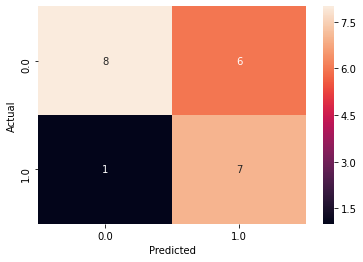

In [169]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': lr_pred
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [170]:
# Print of the Classification Report

print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.57      0.70        14
         1.0       0.54      0.88      0.67         8

    accuracy                           0.68        22
   macro avg       0.71      0.72      0.68        22
weighted avg       0.76      0.68      0.69        22



In [171]:
# Predict the probabilities

pred_proba = lr.predict_proba(X_test)[:,1]

# Get the false_positive_rate, true positive_rate and thresold

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba)

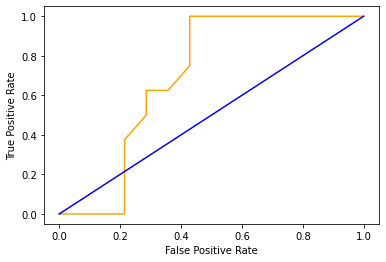

In [172]:
# Plot the ROC curve

plt.plot(false_positive_rate, true_positive_rate, color = 'orange')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [173]:
# Create a function tht converts the predict probabilities to a data frame that compares to the test dataset.
# This will be done in order to evaluate different thresholds in order to see if I can improve the performance with
# different thresholds

def df_converter_test(pred_prob):
    df = pd.DataFrame()
    df['pred_prob'] = pred_prob
    df['test'] = y_test
    return df

# Create a function that converts the predicted probabilities into binary results

def predictor(threshold):
    predictions = []
    for pred_prob in pred_prob_list:
        if pred_prob < threshold:
            predictions.append(0)
        else:
            predictions.append(1)
    return predictions

In [174]:
# See the unique values for the predicted probabilites

np.unique(pred_proba)

array([0.14305717, 0.15202693, 0.18211376, 0.21140828, 0.26056898,
       0.48598082, 0.48615404, 0.48915881, 0.52550653, 0.528168  ,
       0.57226849, 0.58313482, 0.66154937, 0.66393576, 0.68752403,
       0.76486392, 0.82714153, 0.83064447])

In [175]:
# Apply the defined function to evaluate different thresholds

# Convert the predicted probabilities to a data frame

df = df_converter_test(pred_prob = pred_proba)

# Have the values as a list

pred_prob_list = list(df['pred_prob'])

#Establish the thresholds

thresholds = [0.4, 0.5, 0.6]


In [176]:
# Add the new columns witht the selected threshold

df['threshold_0.5'] = predictor(threshold = 0.5)
df['threshold_0.6'] = predictor(threshold = 0.6)
df['threshold_0.7'] = predictor(threshold = 0.7)

In [177]:
# Accuracy Score of each threshold

print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df['threshold_0.6'])))
print('Accuracy Score with a threshold of 0.7: {}'.format(accuracy_score(y_test, df['threshold_0.7'])))

Accuracy Score with a threshold of 0.5: 0.6818181818181818
Accuracy Score with a threshold of 0.6: 0.6363636363636364
Accuracy Score with a threshold of 0.7: 0.5454545454545454


#### Decision Tree Classifier

In [178]:
# Do the Grid Search Cross Validation 

param_grid = {
             'criterion': ['gini', 'entropy'],
             'max_depth': [3, 5, 7],
             'min_samples_split':[2, 4, 6, 8]
             }

dt = DecisionTreeClassifier()
cv_dt = GridSearchCV(dt, param_grid, cv = 5)
cv_dt_fit = cv_dt.fit(X_train, y_train)

#Print the best parameter
print(cv_dt_fit.best_params_)

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}


In [179]:
# Make the model with the best hyperparameters

dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7, min_samples_split = 4)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [180]:
# Check out train score

print('The model score for the Decision Tree Classifier is {}'.format(dt.score(X_train, y_train)))

The model score for the Decision Tree Classifier is 0.8571428571428571


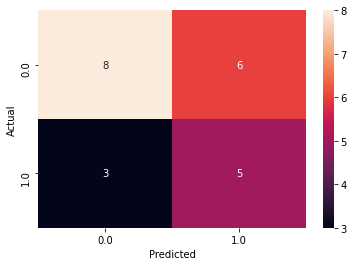

In [181]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': dt_pred
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [182]:
# Print of the Classification Report

print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.57      0.64        14
         1.0       0.45      0.62      0.53         8

    accuracy                           0.59        22
   macro avg       0.59      0.60      0.58        22
weighted avg       0.63      0.59      0.60        22



In [183]:
# Print the accuracy of the model

print('Accuracy of the Decision Tree Classifier model: {}'.format(accuracy_score(y_test, dt_pred)))

Accuracy of the Decision Tree Classifier model: 0.5909090909090909


In [184]:
# Predict the probabilities

pred_proba = dt.predict_proba(X_test)[:,1]

# Get the false_positive_rate, true positive_rate and thresold

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba)

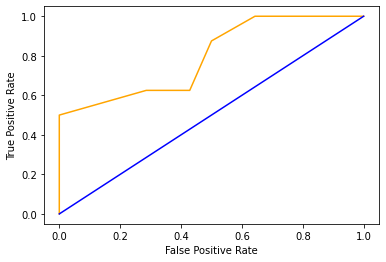

In [185]:
# Plot the ROC curve

plt.plot(false_positive_rate, true_positive_rate, color = 'orange')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [186]:
# See the unique values for the predicted probabilites

np.unique(pred_proba)

array([0.        , 0.33333333, 0.4       , 0.66666667, 0.76470588,
       1.        ])

In [187]:
# Add the new columns witht the selected threshold

df['threshold_0.5'] = predictor(threshold = 0.5)
df['threshold_0.6'] = predictor(threshold = 0.6)
df['threshold_0.7'] = predictor(threshold = 0.7)

In [188]:
# Accuracy Score of each threshold

print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df['threshold_0.6'])))
print('Accuracy Score with a threshold of 0.7: {}'.format(accuracy_score(y_test, df['threshold_0.7'])))

Accuracy Score with a threshold of 0.5: 0.6818181818181818
Accuracy Score with a threshold of 0.6: 0.6363636363636364
Accuracy Score with a threshold of 0.7: 0.5454545454545454


#### Random Forest Classifier

In [189]:
# Do the Grid Search Cross Validation
param_grid = {'n_estimators': [100, 250],
              'criterion' : ['gini', 'entropy'],
              'max_depth': [3, 5, 7],
              }

rf = RandomForestClassifier()
cv_rf = GridSearchCV(rf, param_grid, cv = 5)
cv_rf_fit = cv_rf.fit(X_train, y_train)

#Print the best parameter
print(cv_rf_fit.best_params_)

{'criterion': 'gini', 'max_depth': 3, 'n_estimators': 250}


In [190]:
# Make the model with the best hyperparameters

rf = RandomForestClassifier(criterion = 'gini',max_depth = 5, n_estimators = 100)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [191]:
# Check out train score
print('The model score for the Decision Tree Classifier is {}'.format(rf.score(X_train, y_train)))

The model score for the Decision Tree Classifier is 0.8888888888888888


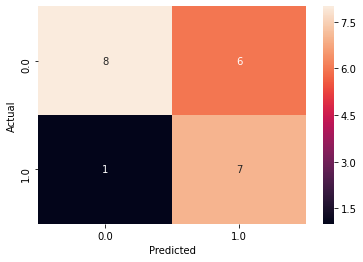

In [192]:
# Plot of the confusion matrix
grid = {'y_test':    y_test,
        'pred': rf_pred
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [193]:
# Print of the Classification Report

print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.57      0.70        14
         1.0       0.54      0.88      0.67         8

    accuracy                           0.68        22
   macro avg       0.71      0.72      0.68        22
weighted avg       0.76      0.68      0.69        22



In [194]:
print('Accuracy of the Random Forest Classifier model: {}'.format(accuracy_score(y_test, rf_pred)))

Accuracy of the Random Forest Classifier model: 0.6818181818181818


In [195]:
# Predict the probabilities

pred_proba = rf.predict_proba(X_test)[:,1]

# Get the false_positive_rate, true positive_rate and thresold

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba)

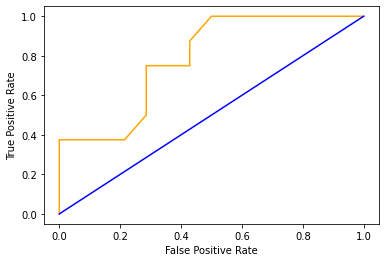

In [196]:
# Plot the ROC curve

plt.plot(false_positive_rate, true_positive_rate, color = 'orange')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [197]:
# Check out the unique values for the probabilities for the Random Forest Classifier

np.unique(pred_proba)

array([0.13175618, 0.21754808, 0.2399816 , 0.28874141, 0.28886809,
       0.32930403, 0.40040885, 0.45962312, 0.50716017, 0.52489782,
       0.58890289, 0.60919713, 0.61257965, 0.62383431, 0.68244403,
       0.73670016, 0.7974318 , 0.86252756])

In [198]:
# Apply the defined function to evaluate different thresholds

df = df_converter_test(pred_prob = pred_proba)

pred_prob_list = list(df['pred_prob'])

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]


In [199]:
# Add the new columns witht the selected threshold

df['threshold_0.3'] = predictor(threshold = 0.3)
df['threshold_0.4'] = predictor(threshold = 0.4)
df['threshold_0.5'] = predictor(threshold = 0.5)
df['threshold_0.6'] = predictor(threshold = 0.6)
df['threshold_0.7'] = predictor(threshold = 0.7)
df['threshold_0.8'] = predictor(threshold = 0.8)

In [200]:
# Accuracy Score of each threshold

print('Accuracy Score with a threshold of 0.3: {}'.format(accuracy_score(y_test, df['threshold_0.3'])))
print('Accuracy Score with a threshold of 0.4: {}'.format(accuracy_score(y_test, df['threshold_0.4'])))
print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df['threshold_0.6'])))
print('Accuracy Score with a threshold of 0.7: {}'.format(accuracy_score(y_test, df['threshold_0.7'])))
print('Accuracy Score with a threshold of 0.8: {}'.format(accuracy_score(y_test, df['threshold_0.8'])))

Accuracy Score with a threshold of 0.3: 0.5909090909090909
Accuracy Score with a threshold of 0.4: 0.6363636363636364
Accuracy Score with a threshold of 0.5: 0.6818181818181818
Accuracy Score with a threshold of 0.6: 0.6818181818181818
Accuracy Score with a threshold of 0.7: 0.7727272727272727
Accuracy Score with a threshold of 0.8: 0.6818181818181818


#### K-Nearest Neighbors

In [201]:
# Create the parameter grid

param_grid = {'n_neighbors': [5, 7, 9],
             'weights': ['uniform', 'distance'],
                }

#Create the model
knn = KNeighborsClassifier()

# Make the Grid Search Cross Validation
cv_knn = GridSearchCV(knn, param_grid, cv = 5)

cv_knn.fit(X_train, y_train)

#Print the best parameter
print(cv_knn.best_params_)

{'n_neighbors': 7, 'weights': 'distance'}


In [202]:
# Create the model with the optimized parameter
kn = KNeighborsClassifier(n_neighbors = 7, algorithm = 'auto', weights = 'distance')
kn.fit(X_train, y_train)
pred_kn = kn.predict(X_test)

In [203]:
# Check out train score
print('The model score for the K-Nearest Neighbor Classifier is {}'.format(kn.score(X_train, y_train)))

The model score for the K-Nearest Neighbor Classifier is 0.9523809523809523


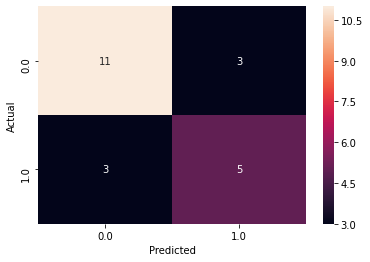

In [204]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': pred_kn
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [205]:
# Print the Classification Report

print(classification_report(y_test, pred_kn))

              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79        14
         1.0       0.62      0.62      0.62         8

    accuracy                           0.73        22
   macro avg       0.71      0.71      0.71        22
weighted avg       0.73      0.73      0.73        22



In [206]:
print('Accuracy of the KNeighbors Classifier model: {}'.format(accuracy_score(y_test, pred_kn)))

Accuracy of the KNeighbors Classifier model: 0.7272727272727273


In [207]:
# Predict the probabilities

pred_proba = kn.predict_proba(X_test)[:,1]

# Get the false_positive_rate, true positive_rate and thresold

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba)

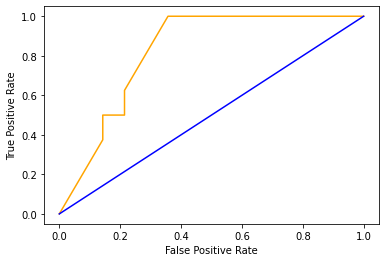

In [208]:
# Plot the ROC curve

plt.plot(false_positive_rate, true_positive_rate, color = 'orange')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [209]:
# See the unique values for the predicted probabilities

np.unique(pred_proba)

array([0.        , 0.27349763, 0.27385775, 0.43613021, 0.5       ,
       0.57795188, 0.58257868, 0.71428571, 1.        ])

In [210]:
# Apply the defined function to evaluate different thresholds

df = df_converter_test(pred_prob = pred_proba)

pred_prob_list = list(df['pred_prob'])

thresholds = [0.5, 0.7, 0.8]

In [211]:
# Add the new columns witht the selected threshold

df['threshold_0.5'] = predictor(threshold = 0.5)
df['threshold_0.6'] = predictor(threshold = 0.6)
df['threshold_0.7'] = predictor(threshold = 0.7)
df['threshold_0.8'] = predictor(threshold = 0.8)

In [212]:
# Accuracy Score of each threshold

print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df['threshold_0.6'])))
print('Accuracy Score with a threshold of 0.7: {}'.format(accuracy_score(y_test, df['threshold_0.7'])))
print('Accuracy Score with a threshold of 0.8: {}'.format(accuracy_score(y_test, df['threshold_0.8'])))

Accuracy Score with a threshold of 0.5: 0.7727272727272727
Accuracy Score with a threshold of 0.6: 0.7272727272727273
Accuracy Score with a threshold of 0.7: 0.7272727272727273
Accuracy Score with a threshold of 0.8: 0.6818181818181818


#### Extra Trees Classifier

In [213]:
# Do the Grid Search Cross Validation

param_grid = {'n_estimators':[100, 250],
              'criterion' : ['gini', 'entropy'],
              'max_depth':[3,5,7]
                }

#Create the model

et = ExtraTreesClassifier()

# Make the Grid Search Cross Validation

cv_et = GridSearchCV(et, param_grid, cv = 5)

cv_et.fit(X_train, y_train)

#Print the best parameter

print(cv_et.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}


In [214]:
# Create the model with the best hyperparameters

et = ExtraTreesClassifier(criterion = 'gini', max_depth = 3, n_estimators = 100)
et.fit(X_train, y_train)
pred_et = et.predict(X_test)

In [215]:
# Check out train score

print('The model score for the Extra Trees Classifier is {}'.format(et.score(X_train, y_train)))

The model score for the Extra Trees Classifier is 0.8571428571428571


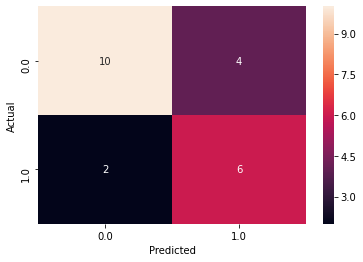

In [216]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': pred_et
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [217]:
# Print the Classification Report

print(classification_report(y_test, pred_et))

              precision    recall  f1-score   support

         0.0       0.83      0.71      0.77        14
         1.0       0.60      0.75      0.67         8

    accuracy                           0.73        22
   macro avg       0.72      0.73      0.72        22
weighted avg       0.75      0.73      0.73        22



In [218]:
print('Accuracy of the Extra Trees Classifier model: {}'.format(accuracy_score(y_test, pred_et)))

Accuracy of the Extra Trees Classifier model: 0.7272727272727273


In [219]:
# Predict the probabilities

pred_proba = et.predict_proba(X_test)[:,1]

# Get the false_positive_rate, true positive_rate and thresold

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba)

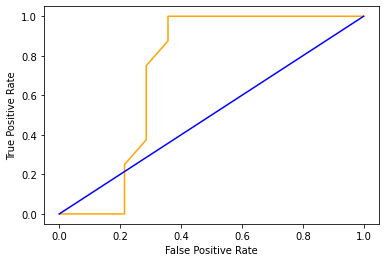

In [220]:
# Plot the ROC curve

plt.plot(false_positive_rate, true_positive_rate, color = 'orange')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [221]:
# See the unique values for the predicted probabilities

np.unique(pred_proba)

array([0.22068639, 0.2703317 , 0.31663903, 0.4222234 , 0.42706478,
       0.43952034, 0.446617  , 0.45946962, 0.49636085, 0.49648484,
       0.55715516, 0.58067888, 0.58592222, 0.60485848, 0.70105374,
       0.70612843, 0.71358244, 0.73317071])

In [222]:
# Apply the defined function to evaluate different thresholds

df = df_converter_test(pred_prob = pred_proba)

pred_prob_list = list(df['pred_prob'])

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

In [223]:
# Add the new columns witht the selected threshold

df['threshold_0.3'] = predictor(threshold = 0.3)
df['threshold_0.4'] = predictor(threshold = 0.4)
df['threshold_0.5'] = predictor(threshold = 0.5)
df['threshold_0.6'] = predictor(threshold = 0.6)
df['threshold_0.7'] = predictor(threshold = 0.7)

In [224]:
# Accuracy Score of each threshold

print('Accuracy Score with a threshold of 0.3: {}'.format(accuracy_score(y_test, df['threshold_0.3'])))
print('Accuracy Score with a threshold of 0.4: {}'.format(accuracy_score(y_test, df['threshold_0.4'])))
print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df['threshold_0.6'])))
print('Accuracy Score with a threshold of 0.7: {}'.format(accuracy_score(y_test, df['threshold_0.7'])))

Accuracy Score with a threshold of 0.3: 0.45454545454545453
Accuracy Score with a threshold of 0.4: 0.5
Accuracy Score with a threshold of 0.5: 0.7272727272727273
Accuracy Score with a threshold of 0.6: 0.5909090909090909
Accuracy Score with a threshold of 0.7: 0.5909090909090909


### Voting Classifier

In [225]:
# KNeighbors Classifier

clf1 = KNeighborsClassifier(n_neighbors = 7, algorithm = 'auto', weights = 'distance')

#Logistic Regression

clf2 = LogisticRegression(C = 1.0, penalty = 'l2', tol = 0.01)

# Extra Trees Classifier

clf3 = ExtraTreesClassifier(criterion = 'gini', max_depth = 3, n_estimators = 100)

# Create the Voting Classifier with soft voting because all models performed similarly

clf_voting = VotingClassifier(estimators = [('est1', clf1), ('est2', clf2),
                                           ('est3', clf3)],
                               voting = 'hard')
#Fit and predict

clf_voting.fit(X_train, y_train)
pred_voting = clf_voting.predict(X_test)

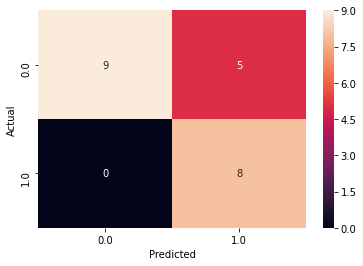

In [226]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': pred_voting
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [227]:
# Print the Classification Report

print(classification_report(y_test, pred_voting))

              precision    recall  f1-score   support

         0.0       1.00      0.64      0.78        14
         1.0       0.62      1.00      0.76         8

    accuracy                           0.77        22
   macro avg       0.81      0.82      0.77        22
weighted avg       0.86      0.77      0.78        22



In [228]:
print('Accuracy of the Voting Classifier model: {}'.format(accuracy_score(y_test, pred_voting)))

Accuracy of the Voting Classifier model: 0.7727272727272727


##### Weighting to the classifier

In [229]:
# Create empty lists that will storage the different weights

weights1 = []
weights2 = []
weights3 = []
scores = []

# Create a for loop to evaluate different combinations of weights

for i in np.arange(0.1,1, 0.1):
    for j in np.arange(0.1,1, 0.1):
        for k in np.arange(0.1,1, 0.1):
            clf_voting = VotingClassifier(estimators = [('est1', clf1), ('est2', clf2),
                                           ('est3', clf3)], voting = 'soft', weights = [i, j, k])
            clf_voting.fit(X_train, y_train)
            pred = clf_voting.predict(X_test)
            score = accuracy_score(y_test, pred)
            scores.append(score)
            weights1.append(i)
            weights2.append(j)
            weights3.append(k)

In [230]:
# Save the results in a data frame

test_scores = pd.DataFrame()
test_scores['Weight1'] = weights1
test_scores['Weight2'] = weights2
test_scores['Weight3'] = weights3
test_scores['Test Score'] = scores

# Create an additional column to save the sum of all the weights

test_scores['sum_weights'] = test_scores['Weight1'].add(test_scores['Weight2']).add(test_scores['Weight3'])

#We are only getting the rows that the sum of all weights were equal to one

condition = test_scores['sum_weights'] == 1

test_scores = test_scores.loc[condition]

In [231]:
# Sort the values to see the different test scores depending on the weights
test_scores.sort_values(by = 'Test Score', ascending = False).head(15)

,Weight1,Weight2,Weight3,Test Score,sum_weights
335,0.5,0.2,0.3,0.818182,1.0
263,0.4,0.3,0.3,0.818182,1.0
423,0.6,0.3,0.1,0.818182,1.0
415,0.6,0.2,0.2,0.818182,1.0
247,0.4,0.1,0.5,0.818182,1.0
351,0.5,0.4,0.1,0.818182,1.0
343,0.5,0.3,0.2,0.818182,1.0
255,0.4,0.2,0.4,0.818182,1.0
327,0.5,0.1,0.4,0.818182,1.0
279,0.4,0.5,0.1,0.818182,1.0


In [232]:
# Create the Voting Classifier with the most equally weighted because all models performed similarly

clf_voting = VotingClassifier(estimators = [('est1', clf1), ('est2', clf2),
                                           ('est3', clf3)], voting = 'soft', weights = [0.4, 0.3, 0.3])

#Fit and predict

clf_voting.fit(X_train, y_train)
pred_voting = clf_voting.predict(X_test)

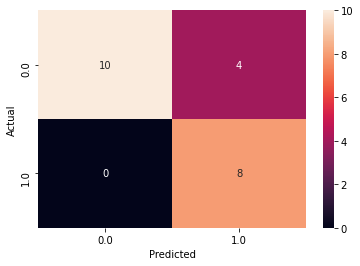

In [233]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': pred_voting
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [234]:
# Print the Classification Report

print(classification_report(y_test, pred_voting))

              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83        14
         1.0       0.67      1.00      0.80         8

    accuracy                           0.82        22
   macro avg       0.83      0.86      0.82        22
weighted avg       0.88      0.82      0.82        22



##### Final Conclusion

From all the models we tried, the model that performed the best was the voting classifiers. To make this classifier, I took into consideration the following:

- The classifiers needed to have similar accuracy on the test set.
- The classifiers needed to be if possible, weak classifiers.
- The model with higher accuracy and f1-score was selected as the final model

Because of the reasons, the model selected was the voting classifiers with KNeighbors Classifier, Logistic Regression and Extra Trees Classifier. By using those three classifiers in a voting classifier, I was able to get an accuracy of 0.82, and an f1-score of 0.83 for the unhappy customers and 0.80 for happy customers. 

### Feature Importance

In [235]:
# To see the most important features, we are doing a permutation test with the voting classifier

r = permutation_importance(clf_voting , X_test, y_test, n_repeats = 30, random_state = 0)
                           
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{data3_balanced.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

complete_order_1.00.117 +/- 0.051
delivered_time_54.52477466435520.086 +/- 0.040


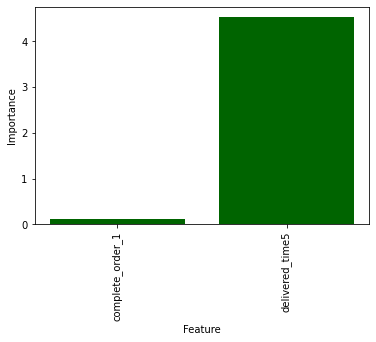

In [236]:
# Plot the feature most important

features = ['complete_order_1', 'delivered_time5']
importance = [0.117, 4.5247746643552]

plt.bar(x = features, height = importance, color = 'darkgreen')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation = 90)
plt.show()

###### To finalize, the features that mainly impact if a customer is unhappy is if the order was incomplete and what determines if the customer is happy is if the delivered time was good.